<h1 STYLE="padding-left:1em;text-align: center;">Projet 04 : Segmentation des clients d'un site e-commerce Olist </h1> 

#  Introduction  
<p STYLE="padding-left:1em;text-align:justify;">Olist souhaite fournir à ses équipes d'e-commerce une segmentation de ses clients utilisable au quotidien pour leurs campagnes de communication.

<p STYLE="padding-left:1em;text-align:justify;">L'objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

<p STYLE="padding-left:1em;text-align:justify;">Nous allons fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

<p STYLE="padding-left:1em;text-align:justify;">Nous utilisererons donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires.

# Sommaire
<a href="#1" STYLE="padding-left:1em;color:black"><b>Etape 1 : Importation des librairies et des fonctions graphiques</b></a><br>
<a href="#2" STYLE="padding-left:1em;color:black"><b>Etape 2 : Importation des données et observation des variables pertinentes </b></a><br>
<a href="#3" STYLE="padding-left:1em;color:black"><b>Etape 3 : Segmentation des clients avec l'algorithme du K-means</b></a><br>
<a href="#3.1" STYLE="padding-left:2em;color:black">3.1 Prepocessor</a><br>
<a href="#3.2" STYLE="padding-left:2em;color:black">3.2 Clustering des clients</a><br>
<a href="#3.2.1" STYLE="padding-left:3em;color:black">3.2.1 K-means</a><br>
<a href="#3.2.2" STYLE="padding-left:3em;color:black">3.2.2 K-means après réduction dimensionnelle - PCA</a><br>
<a href="#3.3" STYLE="padding-left:2em;color:black">3.3 Clustering des clients sans les catégories de produits</a><br>
<a href="#3.3.1" STYLE="padding-left:3em;color:black">3.3.1 K-means</a><br>
<a href="#3.3.2" STYLE="padding-left:3em;color:black">3.3.2 K-means après réduction dimensionnelle - PCA</a><br>
<a href="#4" STYLE="padding-left:1em;color:black"><b>Etape 4 : Segmentation des clients avec d'autres algorithmes de clustering </b></a><br>
<a href="#4.1" STYLE="padding-left:2em;color:black">4.1 Algorithme du DBSCAN</a><br>
<a href="#4.2" STYLE="padding-left:2em;color:black">4.2 Algorithme d'agglomerative hierarchical clustering</a><br>

# <a STYLE="color:black" id="1">Etape 1 : Importation des librairies et des fonctions graphiques 

In [2]:
%matplotlib inline

from ast import literal_eval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.collections import LineCollection

import scipy.stats as stats

from time import time
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.manifold import TSNE, locally_linear_embedding, LocallyLinearEmbedding

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, homogeneity_score, adjusted_mutual_info_score ,davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from scipy.cluster.hierarchy import dendrogram, linkage
from math import radians, cos, sin, asin, sqrt, pi

from sklearn.compose import ColumnTransformer , make_column_transformer
from sklearn.pipeline import Pipeline , make_pipeline
from joblib import parallel_backend, Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth', 200)

In [3]:
from joblib import Memory

location = './cachedir/clustering/'
mem = Memory(location,mmap_mode='r+',verbose=0)
mem.clear(warn=False)

<p STYLE="padding-left:1em;color:blue;"><b>Configuration générale des différents graphiques <font>

In [4]:
plt.rcdefaults()
font_title = {'color': 'blue','weight': 'bold','size': 14}
font_label = {'size': 12}
font_ticks = 12
font_legend = 10

c = []
[c.append(plt.cm.tab20(i)) for i in range(20)]
c20 = []
[c20.append(plt.cm.tab10(i)) for i in range(10)]
[c20.append(plt.cm.Pastel1(i)) for i in range(8)]

def config_plt(plot = plt, ax = None, title = 'titre', X_name = 'x' , Y_name = 'y' , legend = ''):
    if plot == plt :
        plot.title(title,fontdict=font_title)
        plot.xlabel(X_name,fontdict=font_label)
        plot.ylabel(Y_name,fontdict=font_label)
        plot.xticks(fontsize =font_ticks)
        plot.yticks(fontsize =font_ticks)
        if legend is not None:
            plot.legend(title = legend , fontsize =font_legend)
    else : 
# Sub-plot
        ax.set_title(title,fontdict=font_title)
        ax.set_xlabel(X_name,fontdict=font_label)
        ax.set_ylabel(Y_name,fontdict=font_label)
        ax.tick_params(axis='x', labelsize=font_ticks)
        ax.tick_params(axis='y', labelsize=font_ticks)
        if legend is not None: 
            ax.legend(title = legend , fontsize =font_legend)

In [5]:
def plot_(DF, x_cols,cols, categorie= None,Nb_cols=2,marker = '',length=None,width=None,x_lim=None,y_lim =None,title=None,x_name=None,y_name=None,legend=None):
    label = dict() if 'label' not in globals() else globals()['label']
    x_cols = [x_cols] if np.array([x_cols]).size == 1 else x_cols 
    cols = [cols]  if np.array([cols]).size == 1 else cols 
    Nb_var =  1 if np.array([cols]).size == 1 else len(cols)
    Nb_row = int(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    length = 4*Nb_row if length is None else length
    fig = plt.figure(figsize=(width,length))    
    for i in range(0,Nb_var):
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1)
        if categorie is None : 
            if len(x_cols)==1:
                axes.plot(DF[x_cols[0]],DF[cols[i]],color = c[0],marker = marker)
            else : 
                axes.plot(DF[x_cols[i]],DF[cols[i]],color = c[0],marker = marker)
        else :
            k=0
            for cat in DF[categorie].unique():
                DF_frac = DF[DF[categorie] == cat]
                if len(x_cols)==1:
                    axes.plot(DF_frac[x_cols[0]],DF_frac[cols[i]],color = c[k],marker = marker,label = cat)
                else : 
                    axes.plot(DF_frac[x_cols[i]],DF_frac[cols[i]],color = c[k],marker = marker, label = cat)
                k+=1
#             legend = str(cat if label.get(cat) is None else label.get(cat))
            
        axes.set_xlim(x_lim) if x_lim !=None else None    
        axes.set_ylim(y_lim) if y_lim !=None else None
        
        axes.grid(visible=True,axis='x')
        
        (axes.set_xticks(DF[x_cols[0]]) if axes is not plt else axes.xticks(DF[x_cols[0]])) if DF[x_cols[0]].size<=15 else None 
        
        j = 0 if len(x_cols)==1 else i
        title_plt = '' if title is None else [title if len([cols]) == 1 else title[i]]    
        if x_name is None : 
            x = str(x_cols[j] if label.get(x_cols[j]) is None else label.get(x_cols[j]))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[j]
        if y_name is None : 
            y = str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
            
        config_plt(plot = 'None', ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
        fig.tight_layout()
    plt.show() 

def plot_scatter(DF, x_cols,cols, categorie= None,Nb_cols=2,length=None,width=None,x_lim=None,y_lim =None,title=None,x_name=None
                 ,y_name=None,legend=None):
    
    label = dict() if 'label' not in globals() else globals()['label']
    x_cols = [x_cols] if np.array([x_cols]).size == 1 else x_cols 
    cols = [cols]  if np.array([cols]).size == 1 else cols 
    Nb_var =  1 if np.array([cols]).size == 1 else len(cols)
    Nb_row = int(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    length = 4*Nb_row if length is None else length
    fig = plt.figure(figsize=(width,length)) 
    for i in range(0,Nb_var):
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1)
        if categorie is None : 
            if len(x_cols)==1:
                axes.scatter(DF[x_cols[0]],DF[cols[i]],color = c[0],s=1.75)
            else : 
                axes.scatter(DF[x_cols[i]],DF[cols[i]],color = c[0],s=1.75)
        else :
            k=0
            for cat in DF[categorie].unique():
                DF_frac = DF[DF[categorie] == cat]
                if len(x_cols)==1:
                    axes.scatter(DF_frac[x_cols[0]],DF_frac[cols[i]],color = c[k],s=1.75 ,label = cat)
                else : 
                    axes.scatter(DF_frac[x_cols[i]],DF_frac[cols[i]],color = c[k],s=1.75, label = cat)
                k+=1
            
        axes.set_xlim(x_lim) if x_lim !=None else None    
        axes.set_ylim(y_lim) if y_lim !=None else None
        
        j = 0 if len(x_cols)==1 else i
        title_plt = '' if title is None else title if len([cols]) == 1 else title[i]    
        if x_name is None : 
            x = str(x_cols[j] if label.get(x_cols[j]) is None else label.get(x_cols[j]))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[j]
        if y_name is None : 
            y = str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
            
        config_plt(plot = 'None', ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
    fig.tight_layout()
    plt.show() 

def plot_bar(DF, x_cols, y_cols = None , Nb_cols=2,height=None,width=None,title=None,x_name=None,y_name=None,legend=None):
    label = dict() if 'label' not in globals() else globals()['label']
    x_cols = [x_cols]  if np.array([x_cols]).size == 1 else x_cols
    y_cols = None if y_cols is None else [y_cols] if np.array([y_cols]).size == 1 else y_cols  
    Nb_var= (1 if len(x_cols)==1 else len(x_cols)) if y_cols is None else len(y_cols) if len(y_cols) > 1 else 1  
    
    Nb_row = int(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    height = 4*Nb_row if height is None else height
    fig = plt.figure(figsize=(width,height)) 

    for i in range(0,Nb_var):
        cols = x_cols[i] if y_cols is None else x_cols[0]
        if (DF[cols].nunique()>16) & (DF[cols].dtypes == object) & (Nb_cols == 1):
            width = min(DF[cols].nunique()/4,30) 
            fig = plt.figure(figsize=(width,height))
        elif (Nb_cols == 1) :
            width = 4*Nb_cols 
            fig = plt.figure(figsize=(width,height))
        elif (DF[cols].nunique()>16) & (DF[cols].dtypes == object) & ( Nb_cols > 1) :
            width = min(DF[cols].nunique()*Nb_cols/4,30)
            fig.set_figwidth(width)
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1) if Nb_cols>1 else plt
        if y_cols is None :
            count = DF.groupby(by=DF[cols])[cols].count().sort_values(ascending = False)
            X = count.index.values
            Y = count.values
        else :
            X = DF.groupby(cols).agg({ y_cols[i] : 'sum'}).reset_index().iloc[:,0]
            Y = DF.groupby(cols).agg({ y_cols[i] : 'sum'}).reset_index().iloc[:,1]
            
        if title is None :
            titre = cols if y_cols is None else y_cols[i]
            title_plt = 'Distribution :\n ' + str(titre if label.get(titre) is None else label.get(titre))
        else : 
            title_plt = title if np.array([cols]).size == 1 else title[i]
        if x_name is None :
            x_nom = cols if y_cols is None else cols
            x = str(x_nom if label.get(x_nom) is None else label.get(x_nom))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[i]
        if y_name is None : 
            y_nom = cols if y_cols is None else y_cols[i]
            y = 'Nombre de '+ str(y_nom if label.get(y_nom) is None else label.get(y_nom))  
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
        
        #plot bar
        if len(X)<=20 : 
            axes.bar(X,Y,color=c[0 : len(X)])        
            for j in range(0,len(X)):
                j = int(j)
                axes.bar(X,Y,width=0,color= c[j],label= X[j])
        else : 
            axes.bar(X,Y,color=c20[0])
            
        (axes.set_xticks(X) if axes is not plt else axes.xticks(X)) if X.size<=20 else None   
        axes.tick_params(axis='x',rotation = 90)
        config_plt(plot = axes, ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
    plt.tight_layout()
    plt.show()   

In [6]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    Nb_row = len(axis_ranks)    
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:
            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(5,5))
            xmin, xmax, ymin, ymax = -1, 1, -1, 1

            # affichage des flèches
            if pcs.shape[1] < 40 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),pcs[d1,:], pcs[d2,:], angles='xy', scale_units='xy', 
                  scale=1, color="black")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.75, color='black'))

            # affichage des noms des variables
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        pos_x = ['right' if x<0 else 'left'] 
                        pos_y = ['top' if y<0 else 'bottom']
                        lim_display = 0.25
                        if x <= -lim_display or x >= lim_display or y <= -lim_display or y >= lim_display :
                            plt.text(x, y, labels[i], fontsize='10', ha=pos_x[0],va=pos_y[0], rotation=label_rotation, 
                                  color="blue", alpha=0.75)
             
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)       
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            x_name = 'F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1))
            y_name = 'F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1))
            title = "Cercle des corrélations (F{} et F{})".format(d1+1, d2+1)
            config_plt(plot = plt , ax = None , title = title , X_name = x_name , Y_name = y_name , legend = None)
            
        plt.show(block=False)
        
def display_scree_plot(pca):
    fig=plt.figure(figsize=(4,4))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    x_name = "rang de l'axe d'inertie"
    y_name = "pourcentage d'inertie"
    title="Eboulis des valeurs propres"
    config_plt(plot = plt , ax = None , title = title , X_name = x_name , Y_name = y_name , legend = None)

    plt.show(block=False)

# <a STYLE="color:black" id="2">Etape 2 : Importation des données et observation des variables 

In [7]:
Data= pd.read_csv('P04_Data_customer.csv')
t_debut = time()

In [8]:
def info_df(dict_df):
    liste_df =[]
    liste_cols = []
    liste_unique = []
    Nb_valeurs = []
    Nb_nuls = []
    Nb_doublons = []
    i = 0
    for nom_df, df in dict_df.items() : 
        for col in df.columns :
            liste_df.append(nom_df)
            liste_cols.append(col)
            Nb_valeurs.append(df[col].shape[0])
            Nb_nuls.append(df[col].isnull().sum())
            try :
                liste_unique.append(df[col].nunique())
                Nb_doublons.append(df[df.duplicated(subset=col)].shape[0])
            except :
                flatten = [val for sublist in df[col].to_list() if sublist is not np.nan for val in sublist ]
                df_flatten = pd.DataFrame([sublist[0] for sublist in flatten], columns = ['liste'])
                liste_unique.append(df_flatten['liste'].nunique())
                Nb_doublons.append(df_flatten[df_flatten.duplicated(subset='liste')].shape[0])       

    info_data = pd.DataFrame(np.array([liste_df,liste_cols,liste_unique,Nb_valeurs,Nb_nuls,Nb_doublons]).T, 
                             columns = ['Nom Data','Nom cols','Valeurs uniques','Nb valeurs', 'Nb valeurs nuls','Nb doublons'])
    return info_data

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Informations générales des différents jeux de données

In [9]:
display(info_df({'Data' :Data }))
Data.info()

Nom Data                        Nom cols Valeurs uniques Nb valeurs  \
0      Data              customer_unique_id           93357      93357   
1      Data               total_money_spent           27869      93357   
2      Data                mean_money_spent           28074      93357   
3      Data           date_of_last_purchase             610      93357   
4      Data                 Nb_of_purchases               9      93357   
5      Data               mean_review_score              27      93357   
6      Data         mean_payment_sequential              31      93357   
7      Data       mean_payment_installments              75      93357   
8      Data    mean_order_item_per_purchage              39      93357   
9      Data                  customer_state              27      93357   
10     Data                   health_beauty              20      93357   
11     Data                         culture              10      93357   
12     Data                  sports_leisure              18      93357   
13     Data                       toys_baby              16      93357   
14     Data                  home_furniture              39      93357   
15     Data              flowers_gifs_stuff              21      93357   
16     Data              construction_tools              14      93357   
17     Data                      technology              26      93357   
18     Data               fashion_accessory              20      93357   
19     Data                            auto              14      93357   
20     Data                        commerce              16      93357   
21     Data                          others              14      93357   
22     Data     security_services_signaling              10      93357   
23     Data  industry_commerce_and_business               8      93357   
24     Data                      food_drink              16      93357   
25     Data                    market_place               7      93357   
26     Data                     credit_card              12      93357   
27     Data                          boleto              10      93357   
28     Data                         voucher              31      93357   
29     Data                      debit_card               5      93357   

   Nb valeurs nuls Nb doublons  
0                0           0  
1                0       65488  
2                0       65283  
3                0       92747  
4                0       93348  
5                0       93330  
6                0       93326  
7                0       93282  
8                0       93318  
9                0       93330  
10               0       93337  
11               0       93347  
12               0       93339  
13               0       93341  
14               0       93318  
15               0       93336  
16               0       93343  
17               0       93331  
18               0       93337  
19               0       93343  
20               0       93341  
21               0       93343  
22               0       93347  
23               0       93349  
24               0       93341  
25               0       93350  
26               0       93345  
27               0       93347  
28               0       93326  
29               0       93352

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93357 entries, 0 to 93356
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              93357 non-null  object 
 1   total_money_spent               93357 non-null  float64
 2   mean_money_spent                93357 non-null  float64
 3   date_of_last_purchase           93357 non-null  int64  
 4   Nb_of_purchases                 93357 non-null  int64  
 5   mean_review_score               93357 non-null  float64
 6   mean_payment_sequential         93357 non-null  float64
 7   mean_payment_installments       93357 non-null  float64
 8   mean_order_item_per_purchage    93357 non-null  float64
 9   customer_state                  93357 non-null  object 
 10  health_beauty                   93357 non-null  float64
 11  culture                         93357 non-null  float64
 12  sports_leisure                  

In [10]:
Data.drop(['total_money_spent'] ,axis = 1, inplace =True , errors = 'ignore')
Data.info()
display(Data.describe())
display(Data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93357 entries, 0 to 93356
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              93357 non-null  object 
 1   mean_money_spent                93357 non-null  float64
 2   date_of_last_purchase           93357 non-null  int64  
 3   Nb_of_purchases                 93357 non-null  int64  
 4   mean_review_score               93357 non-null  float64
 5   mean_payment_sequential         93357 non-null  float64
 6   mean_payment_installments       93357 non-null  float64
 7   mean_order_item_per_purchage    93357 non-null  float64
 8   customer_state                  93357 non-null  object 
 9   health_beauty                   93357 non-null  float64
 10  culture                         93357 non-null  float64
 11  sports_leisure                  93357 non-null  float64
 12  toys_baby                       

mean_money_spent  date_of_last_purchase  Nb_of_purchases  \
count      93357.000000           93357.000000     93357.000000   
mean         160.316648             236.936673         1.033420   
std          219.572062             152.584315         0.209099   
min            9.590000               0.000000         1.000000   
25%           62.370000             113.000000         1.000000   
50%          105.630000             218.000000         1.000000   
75%          176.650000             345.000000         1.000000   
max        13664.080000             694.000000        15.000000   

       mean_review_score  mean_payment_sequential  mean_payment_installments  \
count       93357.000000             93357.000000               93357.000000   
mean            4.128007                 1.043859                   2.965011   
std             1.318213                 0.363318                   2.716192   
min             0.000000                 1.000000                   0.000000   
25%             4.000000                 1.000000                   1.000000   
50%             5.000000                 1.000000                   2.000000   
75%             5.000000                 1.000000                   4.000000   
max             5.000000                26.000000                  26.000000   

       mean_order_item_per_purchage  health_beauty       culture  \
count                  93357.000000   93357.000000  93357.000000   
mean                       1.139511       0.133160      0.020485   
std                        0.527042       0.387012      0.151123   
min                        1.000000       0.000000      0.000000   
25%                        1.000000       0.000000      0.000000   
50%                        1.000000       0.000000      0.000000   
75%                        1.000000       0.000000      0.000000   
max                       21.000000      21.000000      4.000000   

       sports_leisure     toys_baby  home_furniture  flowers_gifs_stuff  \
count    93357.000000  93357.000000    93357.000000        93357.000000   
mean         0.086672      0.073440        0.365738            0.100328   
std          0.321597      0.283029        0.661735            0.325475   
min          0.000000      0.000000        0.000000            0.000000   
25%          0.000000      0.000000        0.000000            0.000000   
50%          0.000000      0.000000        0.000000            0.000000   
75%          0.000000      0.000000        1.000000            0.000000   
max          7.000000     12.000000       15.000000           12.000000   

       construction_tools    technology  fashion_accessory          auto  \
count        93357.000000  93357.000000       93357.000000  93357.000000   
mean             0.021018      0.174713           0.037020      0.043334   
std              0.181361      0.452297           0.205715      0.232480   
min              0.000000      0.000000           0.000000      0.000000   
25%              0.000000      0.000000           0.000000      0.000000   
50%              0.000000      0.000000           0.000000      0.000000   
75%              0.000000      0.000000           0.000000      0.000000   
max             10.000000     20.000000           6.000000     20.000000   

           commerce        others  security_services_signaling  \
count  93357.000000  93357.000000                 93357.000000   
mean       0.047918      0.016179                     0.002060   
std        0.241359      0.141870                     0.064246   
min        0.000000      0.000000                     0.000000   
25%        0.000000      0.000000                     0.000000   
50%        0.000000      0.000000                     0.000000   
75%        0.000000      0.000000                     0.000000   
max        7.000000      6.000000                     6.000000   

       industry_commerce_and_business    food_drink  market_place  \
count                    93357.000000  93357

customer_unique_id  mean_money_spent  \
0      0000366f3b9a7992bf8c76cfdf3221e2            141.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f             27.19   
2      0000f46a3911fa3c0805444483337064             86.22   
3      0000f6ccb0745a6a4b88665a16c9f078             43.62   
4      0004aac84e0df4da2b147fca70cf8255            196.89   
...                                 ...               ...   
93352  fffcf5a5ff07b0908bd4e2dbc735a684           2067.42   
93353  fffea47cd6d3cc0a88bd621562a9d061             84.58   
93354  ffff371b4d645b6ecea244b27531430a            112.46   
93355  ffff5962728ec6157033ef9805bacc48            133.69   
93356  ffffd2657e2aad2907e67c3e9daecbeb             71.56   

       date_of_last_purchase  Nb_of_purchases  mean_review_score  \
0                        111                1                5.0   
1                        114                1                4.0   
2                        536                1                3.0   
3                        320                1                4.0   
4                        287                1                5.0   
...                      ...              ...                ...   
93352                    446                1                5.0   
93353                    261                1                4.0   
93354                    567                1                5.0   
93355                    118                1                5.0   
93356                    483                1                5.0   

       mean_payment_sequential  mean_payment_installments  \
0                          1.0                        8.0   
1                          1.0                        1.0   
2                          1.0                        8.0   
3                          1.0                        4.0   
4                          1.0                        6.0   
...                        ...                        ...   
93352                      1.0                       10.0   
93353                      1.0                        1.0   
93354                      1.0                        1.0   
93355                      1.0                        5.0   
93356                      1.0                        4.0   

       mean_order_item_per_purchage customer_state  health_beauty  culture  \
0                               1.0             SP            0.0      0.0   
1                               1.0             SP            1.0      0.0   
2                               1.0             SC            0.0      0.0   
3                               1.0             PA            0.0      0.0   
4                               1.0             SP            0.0      0.0   
...                             ...            ...            ...      ...   
93352                           2.0             PE            2.0      0.0   
93353                           1.0             BA            0.0      0.0   
93354                           1.0             MT            0.0      0.0   
93355                           1.0             ES            0.0      0.0   
93356                           1.0             PR            1.0      0.0   

       sports_leisure  toys_baby  home_furniture  flowers_gifs_stuff  \
0                 0.0        0.0             1.0                 0.0   
1                 0.0        0.0             0.0                 0.0   
2                 0.0        0.0             0.0                 0.0   
3                 0.0        0.0             0.0                 0.0   
4                 0.0        0.0             0.0                 0.0   
...               ...        ...             ...                 ...   
93352             0.0        0.0             0.0                 0.0   
93353             0.0        1.0             0.0                 0.0   
93354             0.0        0.0             0.0                 0.0   
93355             0.0        0.0             0.0                 1.0   
93356    

# <a STYLE="color:black" id="3">Etape 3 : Segmentation des clients avec l'algorithme du K-means
## <a STYLE="color:black" id="3.1">3.1 Preprocessor</a> 

In [11]:
cols_payment_type = ['credit_card','boleto','voucher','debit_card']
cols_cat_product = ['health_beauty','culture','sports_leisure','toys_baby','home_furniture','flowers_gifs_stuff',
                'construction_tools','technology','auto','fashion_accessory','commerce','others','security_services_signaling',
                'industry_commerce_and_business','food_drink','market_place']
cols_cat_state = list(Data['customer_state'].unique())


cols_var_std = ['mean_money_spent']
cols_cat = list(Data.select_dtypes(exclude=['int64', 'float64']).columns.drop('customer_unique_id', errors = 'ignore' ))
cols_var = list(Data.select_dtypes(include=['int64', 'float64']).columns)

X=Data.drop('customer_unique_id',axis = 1)

In [12]:
scaler = MinMaxScaler()
scaler_std = StandardScaler()
scaler_enc = OneHotEncoder()

def normalize_cat(DF , cols):
    DF_cat = DF[cols]
    max_values= DF_cat.max().max()
    DF_cat[cols]= DF_cat[cols]/max_values
    return DF_cat

preprocessor = ColumnTransformer([('minmax',scaler ,cols_var),('OHE',scaler_enc, cols_cat)])

## <a STYLE="color:black" id="3.2">3.2 Clustering des clients</a>
## <a STYLE="padding-left:1em;color:black" id="3.2.1">3.2.1 K-means </a>

In [13]:
def plot_silhouette_(X , n_clusters ,silhouettes_avg, cluster_labels , sample_silhouette_values ,centers ):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7,)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot pour chaque clusters.")
    ax1.set_xlabel("Valeurs du coefficients de silhouette")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouettes_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    try :
        ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    except : 
        ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0],centers[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k",)
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"% n_clusters,fontsize=14,
        fontweight="bold",)
    fig.tight_layout()
    plt.show()

In [14]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(DF , frame='circle'):
    categories=list(DF)
    num_var = len(categories)
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_var, endpoint=False)
    class RadarAxes(PolarAxes):
        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_var,radius=0.5,lw=2, edgecolor="k")                                     
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,spine_type='circle',path=Path.unit_regular_polygon(num_var))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ self.transAxes)                   
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)
    register_projection(RadarAxes)
    return theta

def radar_plot(DF):  
    Sc = MinMaxScaler()
    DF_clients_mean= DF.groupby('kmeans_label').mean().reset_index().drop('kmeans_label', axis = 1)
    DF_clients = pd.DataFrame(Sc.fit_transform(DF_clients_mean), columns = DF_clients_mean.columns)

    cols = set(DF_clients.columns)
    
    cols_product = None if (cols & set(cols_cat_product)) == set() else cols_cat_product
    cols_state =  None if (cols & set(cols_cat_state)) == set() else cols_cat_state
    cols_payment = None if (cols & set(cols_payment_type)) == set() else cols_payment_type 
    
    cols = cols - set(cols_cat_product) - set(cols_cat_state) - set(cols_payment_type)
    
    listes = [cols,cols_product, cols_payment,cols_state]
    list_cols = [c for c in listes if c is not None]
    
    Nb_rows = 2 if len(list_cols)>2 else 1
    width , length = 10 , 5*Nb_rows

    fig = plt.figure(figsize=(width,length))
    
    for i, col in enumerate(list_cols) :
        data = DF_clients[col]
        theta = radar_factory(data , frame='circle') 
        axes = fig.add_subplot(Nb_rows,2,i+1, projection='radar')
        axes.set_rgrids([0 , 0.25, 0.5 , 0.75 , 1])
        label = []
        for k in range(data.shape[0]) :
            label.append(k)
            axes.plot(theta, data.loc[k], color=c20[k],lw = 3,alpha=0.75, label = k)
#             axes.fill(theta, data.loc[k], facecolor=colors, alpha=0.20)
            axes.set_varlabels(data.columns.to_list())
            plt.legend()

    plt.subplots_adjust(hspace=0.1,wspace=0.5)
    plt.show()
    display(DF_clients)
    
def radar_plot_normalize(DF):     
    DF_clients_mean= DF.groupby('kmeans_label').mean().reset_index().drop('kmeans_label', axis = 1)

    DF_clients = DF_clients_mean.apply(lambda x : x + abs(min(x)) if min(x)<0 else x)
    DF_clients = DF_clients_mean.apply(lambda x : x/max(x))
    
    cols = set(DF_clients.columns)    
    cols_product = None if (cols & set(cols_cat_product)) == set() else cols_cat_product
    cols_state =  None if (cols & set(cols_cat_state)) == set() else cols_cat_state
    cols_payment = None if (cols & set(cols_payment_type)) == set() else cols_payment_type 
    
    cols = cols - set(cols_cat_product) - set(cols_cat_state) - set(cols_payment_type)
    
    listes = [cols,cols_product, cols_payment,cols_state]
    list_cols = [c for c in listes if c is not None]
    
    Nb_rows = 2 if len(list_cols)>2 else 1
    width , length = 10 , 5*Nb_rows

    fig = plt.figure(figsize=(width,length))
    
    for i, col in enumerate(list_cols) :
        data = DF_clients[col]
        theta = radar_factory(data , frame='circle') 
        axes = fig.add_subplot(Nb_rows,2,i+1, projection='radar')
        axes.set_rgrids([0 , 0.25, 0.5 , 0.75 , 1])
        label = []
        for k in range(data.shape[0]) :
            label.append(k)
            axes.plot(theta, data.loc[k], color=c20[k],lw = 3,alpha=0.75, label = k)
#             axes.fill(theta, data.loc[k], facecolor=colors, alpha=0.20)
            axes.set_varlabels(data.columns.to_list())
            plt.legend()

    plt.subplots_adjust(hspace=0.1,wspace=0.5)
    plt.show()
    display(DF_clients,DF_clients_mean)
    
def radar_plot_normalize_cat(DF):     
    DF_clients_mean= DF.groupby('kmeans_label').mean().reset_index().drop('kmeans_label', axis = 1)
   
    cols = set(DF_clients_mean.columns)    
    cols_product = None if (cols & set(cols_cat_product)) == set() else cols_cat_product
    cols_state =  None if (cols & set(cols_cat_state)) == set() else cols_cat_state
    cols_payment = None if (cols & set(cols_payment_type)) == set() else cols_payment_type 
    
    cols = cols - set(cols_cat_product) - set(cols_cat_state) - set(cols_payment_type)
    
    listes = [cols,cols_product, cols_payment,cols_state]
    list_cols = [c for c in listes if c is not None]
      
    DF_clients = DF_clients_mean[cols].apply(lambda x : x/max(x)) 
    for columns in list_cols[1:]:
        DF_clients[columns] = normalize_cat(DF_clients_mean,columns)   
    
    Nb_rows = 2 if len(list_cols)>2 else 1
    width , length = 10 , 5*Nb_rows

    fig = plt.figure(figsize=(width,length))
    
    for i, col in enumerate(list_cols) :
        data = DF_clients[col]
        theta = radar_factory(data , frame='circle') 
        axes = fig.add_subplot(Nb_rows,2,i+1, projection='radar')
        axes.set_rgrids([0 , 0.25, 0.5 , 0.75 , 1])
        label = []
        for k in range(data.shape[0]) :
            plt.legend(label,title = 'clusters',loc=(1.1, 0.6),labelspacing=0.1) if i ==0 else None
            axes.plot(theta, data.loc[k], color=c20[k],lw = 2,alpha=0.75, label = k)
#             axes.fill(theta, data.loc[k], facecolor=c20[k], c)
            axes.set_varlabels(data.columns.to_list())
            label.append(k)
        
    plt.subplots_adjust(hspace=0.1,wspace=0.5)
    plt.show()
    display(DF_clients_mean)

In [15]:
@mem.cache
def KMeans_clusters(X,num_clusters, silhouette_analyse, random_state):
    cls = Pipeline([('KMeans',KMeans(n_clusters=num_clusters, random_state=random_state,n_init=1))])
    cls.fit(X)
    inertie = cls.named_steps['KMeans'].inertia_
    cluster_labels = cls.named_steps['KMeans'].labels_

    silhouettes_avg = silhouette_score(X,cluster_labels,random_state=random_state,sample_size=X.sample(frac=0.10).shape[0])
    davies_bouldin = davies_bouldin_score(X,cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels) if silhouette_analyse == True else None
    centers = cls.named_steps['KMeans'].cluster_centers_ if silhouette_analyse == True else None
    
    return num_clusters,inertie,silhouettes_avg,davies_bouldin,cluster_labels,sample_silhouette_values,centers,


def KMeans_parallel(X,list_clusters,silhouette_analyse=False, score = True , random_state = 0) :
    resultat = Parallel(n_jobs=-1)(delayed(KMeans_clusters)(X,num_clusters,silhouette_analyse,random_state) for num_clusters in list_clusters)
    n_clusters , inertie , silhouettes_avg,davies_bouldin, cluster_labels , sample_silhouette_values , centers = zip(*resultat)
    if score == True :
        score_cls = pd.DataFrame(np.array([n_clusters,silhouettes_avg,inertie,davies_bouldin]).T,
                                 columns = ['n_clusters','silhouettes_avg','inertie','davies_bouldin'])
        plot_(score_cls, 'n_clusters',['silhouettes_avg','inertie','davies_bouldin'],marker = 'o',Nb_cols=3)
    if silhouette_analyse == True :
        for i,cluster in enumerate(n_clusters) : 
            plot_silhouette_(X,cluster, silhouettes_avg[i], cluster_labels[i] ,sample_silhouette_values[i],centers[i])          

In [16]:
def data_clusters(X , n_clusters):
    X_cls = X.copy()
    cls = Pipeline([('KMeans',KMeans(n_clusters=n_clusters, random_state=0,n_init=1))]) 
    cls.fit(X)
    X_cls['kmeans_label'] = cls.named_steps['KMeans'].labels_
    return X_cls 

def clients_clusters(X,n_clusters, preprocessor ):
    x_data = Data.copy()
    cols = preprocessor.transformers_[0][2]+(preprocessor.transformers_[1][2] if preprocessor.transformers_[1][0] != 'remainder' else [])
    x_data = x_data[cols] 
    
    X_cls = X.copy() 
    cls = Pipeline([('KMeans',KMeans(n_clusters=n_clusters, random_state=0,n_init=1))])  
    cls.fit(X)
    x_data['kmeans_label'] = cls.named_steps['KMeans'].labels_
    
    if preprocessor.transformers_[1][0] != 'remainder':
        cols_OHE = preprocessor.transformers_[1][2]
        OHE_preprocessor = ColumnTransformer([preprocessor.transformers_[1]])
        x_OHE = OHE_preprocessor.fit_transform(x_data[cols_OHE]).toarray() 
        x_OHE = pd.DataFrame(x_OHE,index =x_data.index ,  columns = OHE_preprocessor.get_feature_names_out())
        x_final = pd.merge(x_data , x_OHE , how = 'outer' , left_index=True, right_index=True )
        x_final = x_final.rename(label, axis = 1).drop(cols_OHE, axis = 1, errors = 'ignore')
    else : 
        x_final = x_data
    
    return x_final

@mem.cache
def TSNE_transform(X , init = 'pca'):
    t0 = time()
    tsne = TSNE(n_components=2,learning_rate='auto',init=init,random_state=0, n_jobs=-1)
    T = tsne.fit_transform(X.copy())
    data_TSNE = pd.DataFrame(np.array([T[:,0],T[:,1]]).T, columns = ['x','y'])
    print(time() - t0 , 'sec')
    return data_TSNE

def plot_TSNE(TSNE ,Y_labels , legend = None):
    data_plot = pd.merge(TSNE, Y_labels,how = 'outer' , left_index=True, right_index=True).sort_values('kmeans_label')
    plot_scatter(data_plot,'x','y', categorie='kmeans_label' ,Nb_cols=1,length=5,width=5,title='Représentation du jeu de données avec T-SNE',legend = legend)

@mem.cache 
def score_stabilité(X , num_clusters,Y_labels):
    random_list = list({a+np.random.randint(32) for a in range(20)})[:10] 
    resultat = Parallel(n_jobs=-1)(delayed(KMeans_clusters)(X,num_clusters,silhouette_analyse=False,random_state=r) for r in random_list)
    n_clusters , inertia , silhouettes_avg,davies_bouldin, cluster_labels , sample_silhouette_values , centers = zip(*resultat)    
    homo,ARI,AMI = [],[],[]
    for i, j in enumerate(n_clusters):
        homo.append(homogeneity_score(Y_labels, cluster_labels[i]))
        ARI.append(adjusted_rand_score(Y_labels , cluster_labels[i]))
        AMI.append(adjusted_mutual_info_score(Y_labels, cluster_labels[i]))
        
    resultats = pd.DataFrame(np.array([inertia,silhouettes_avg,homo,ARI,AMI]).T,
                             columns=['inertia','silhouettes_avg','homogeneity','ARI','AMI'] )
    return resultats   

In [17]:
X_transform = preprocessor.fit_transform(X)
X_transform = pd.DataFrame(X_transform,columns = preprocessor.get_feature_names_out() )

label = {x : x.replace('std__','').replace('minmax__','').replace('OHE__customer_state_','') for x in X_transform.columns}
X_transform.rename(label, axis = 1, inplace =True)

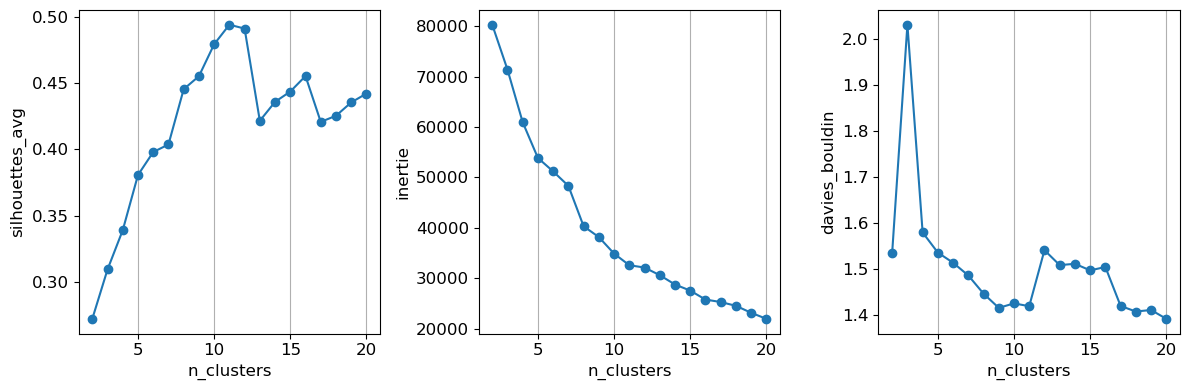

25.80051040649414


In [17]:
t0 = time()
list_clusters = list(range(2,21))
KMeans_parallel(X_transform,list_clusters,silhouette_analyse=False,score=True)
print(time() - t0)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Le balayage du nombre de cluster avec l'algorithme  du K-means montre qu'un nombre de 11 clusters offre les meilleurs scores. En effet, nous recherchons un score maximal pour le coefficient de silhouette, un score minimal pour le coefficient de davies_bouldin et nous utilisons la méthode du coude pour le coefficient d'inertie. 

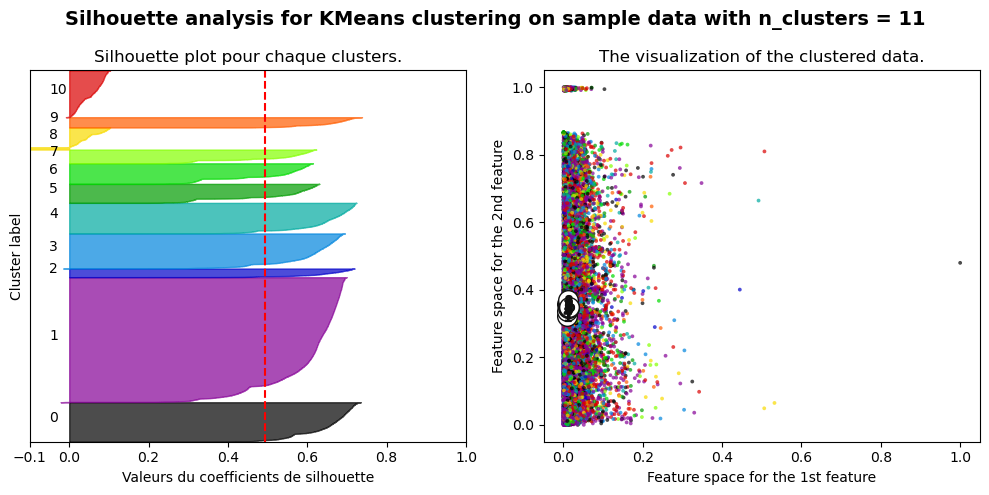

179.49530291557312


In [18]:
t0 = time()
KMeans_parallel(X_transform,[11],silhouette_analyse=True,score=False)
print(time() - t0)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Test de stabilité des clusters à l'initialisation en entrainant plusieurs fois le modèle avec un RandomState différent 

In [19]:
t0 = time()
num_clusters = 11
data_transform = data_clusters(X_transform,num_clusters)
group_clients = clients_clusters(X_transform , num_clusters,preprocessor)
group_clients_bis = data_clusters(X_transform , num_clusters).groupby('kmeans_label').mean().reset_index()

Y_labels = data_clusters(X_transform,num_clusters)['kmeans_label']
display(score_stabilité(X_transform, num_clusters, Y_labels))
display(score_stabilité(X_transform, num_clusters, Y_labels).describe().iloc[[1,2,3,7]])
print(time() - t0)

inertia  silhouettes_avg  homogeneity       ARI       AMI
0  35255.258910         0.476209     0.929721  0.937920  0.930601
1  34207.902298         0.483217     0.919096  0.936007  0.927873
2  33206.017233         0.496526     0.945212  0.958706  0.946056
3  33802.168479         0.492628     0.920347  0.940441  0.925238
4  35402.250111         0.484221     0.872677  0.902041  0.877973
5  34484.252415         0.452846     0.926475  0.945992  0.927011
6  33178.386539         0.485759     0.950445  0.968709  0.954043
7  33921.928676         0.408967     0.914159  0.798312  0.895166
8  35690.216692         0.469649     0.913230  0.938256  0.928545
9  39212.810283         0.467529     0.842336  0.774605  0.876307

inertia  silhouettes_avg  homogeneity       ARI       AMI
mean  34836.119164         0.471755     0.913370  0.910099  0.918881
std    1770.425711         0.025548     0.032679  0.067630  0.026753
min   33178.386539         0.408967     0.842336  0.774605  0.876307
max   39212.810283         0.496526     0.950445  0.968709  0.954043

20.910688161849976


<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Les différentes itérations montrent des inerties proches, une bonne homogénéité et un score de ARI proche de 1 en moyenne nous indiquant une bonne stabilité des segments.  

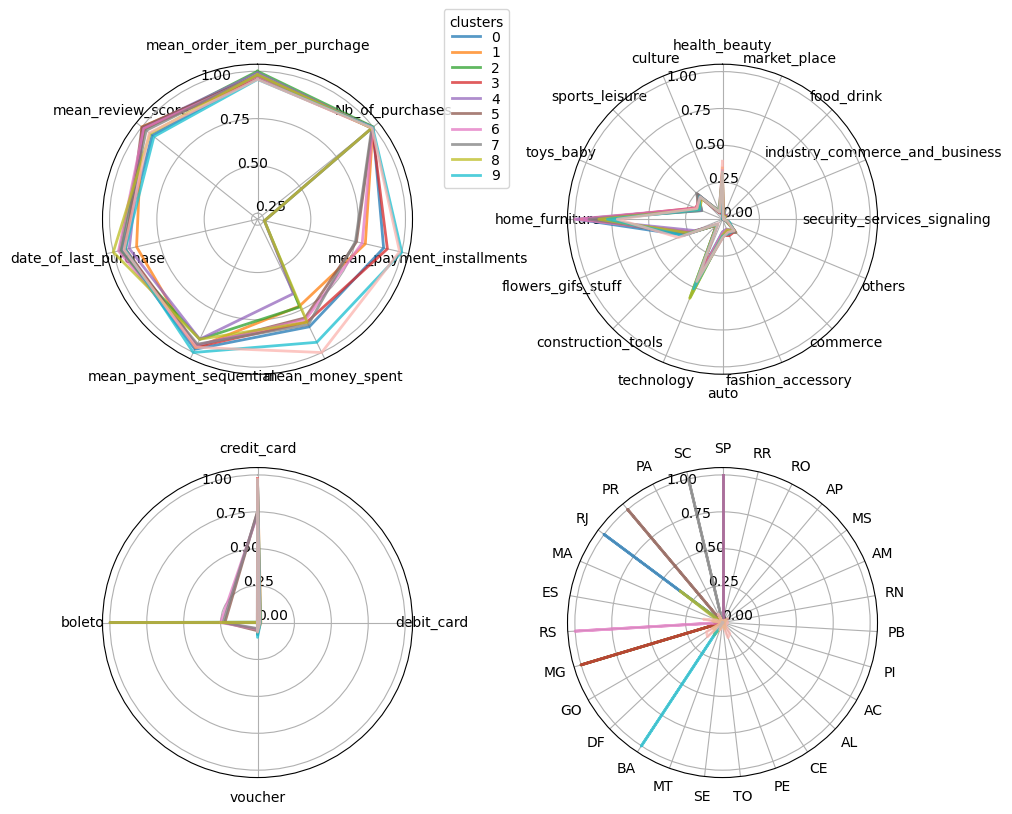

mean_money_spent  date_of_last_purchase  Nb_of_purchases  \
0         169.850127             244.786535         1.036686   
1         145.677583             224.338557         1.036017   
2         146.575996             247.733915         1.038603   
3         164.214071             240.630881         1.031062   
4         130.976532             234.543492         1.028995   
5         159.401833             239.464668         1.033131   
6         161.200182             249.469621         1.034636   
7         167.325410             245.602787         1.028746   
8         164.514924             256.790953         1.028293   
9         188.027087             240.129407         1.034870   
10        200.042156             241.661431         1.030478   

    mean_review_score  mean_payment_sequential  mean_payment_installments  \
0            3.930878                 1.063571                   3.528690   
1            4.226517                 1.054344                   3.140739   
2            4.148284                 1.000066                   1.000985   
3            4.170718                 1.049380                   3.608846   
4            4.201686                 1.000033                   1.000921   
5            4.221710                 1.042567                   2.952698   
6            4.171988                 1.036813                   3.074900   
7            4.102618                 1.031238                   2.931523   
8            3.989938                 1.000060                   1.000105   
9            3.881299                 1.084334                   3.913199   
10           4.016428                 1.050896                   3.868457   

    mean_order_item_per_purchage  health_beauty   culture  sports_leisure  \
0                       1.136910       0.122396  0.017940        0.083862   
1                       1.139738       0.139109  0.019521        0.085621   
2                       1.172159       0.123282  0.019531        0.093903   
3                       1.126288       0.130673  0.018256        0.079265   
4                       1.162116       0.131886  0.024618        0.095306   
5                       1.144545       0.116586  0.023031        0.095984   
6                       1.142044       0.108295  0.020479        0.086091   
7                       1.149729       0.118225  0.020906        0.100561   
8                       1.150973       0.124812  0.024509        0.078978   
9                       1.121658       0.127857  0.022084        0.088015   
10                      1.122580       0.157939  0.020955        0.086176   

    toys_baby  home_furniture  flowers_gifs_stuff  construction_tools  \
0    0.074195        0.397677            0.114073            0.021299   
1    0.075616        0.385244            0.090771            0.021881   
2    0.061121        0.370197            0.096967            0.022518   
3    0.080131        0.368896            0.096833            0.021653   
4    0.061891        0.377129            0.081004            0.023404   
5    0.073862        0.362008            0.106102            0.022122   
6    0.077464        0.402461            0.092492            0.018963   
7    0.065767        0.363918            0.096545            0.020035   
8    0.068721        0.337208            0.098907            0.022527   
9    0.067416        0.313703            0.114917            0.018791   
10   0.075650        0.286888            0.129807            0.016682   

    technology  fashion_accessory      auto  commerce    others  \
0     0.161375           0.029463  0.034654  0.045707  0.017486   
1     0.152509           0.036647  0.043030  0.051679  0.015554   
2     0.231081           0.036075  0.043199  0.048319  0.010570   
3     0.160639           0.048504  0.044439  0.046952  0.017292   
4     0.199216           0.038595  0.041130  0.045995  0.016069   
5     0.178130           0.040190  0.047232  0.045747  0.015936   
6     0.189306           0.029073  0.03

In [20]:
radar_plot_normalize_cat(group_clients)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> La projection des moyennes des différentes variables normalisées en fonction des différents clusters montrent que de nombreuses variables ont peu d'impact sur la segmentation des clients où nous observons des valeurs similaires entre chaque cluster. Les variables indiquant la dépense moyenne par client, le nombre de versement moyen par achat, les moyens de paiements et la localisation des clients sont utilisés par l'algorithme pour segmenter les clients. Nous observons que les catégories de produits n'ont pas d'influence sur les clusters. 

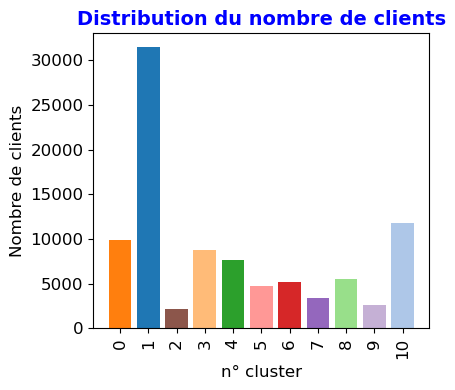

In [21]:
plot_bar(data_transform,'kmeans_label',Nb_cols=2,title='Distribution du nombre de clients',
         x_name='n° cluster',y_name='Nombre de clients')

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Nous observons une répartition inégale des différents clusters où nous avons un tiers des clients situés dans le cluster étiqueté n°1. Ce nombre élévé de client dans le cluster n°1 est du à la région SP qui regroupe la majorité des clients de la base de donnée. 

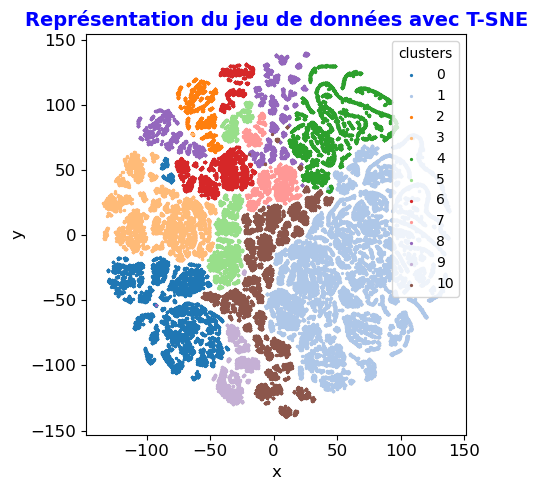

In [20]:
TSNE_X_transform = TSNE_transform(X_transform , init = 'pca')
plot_TSNE(TSNE_X_transform, data_transform['kmeans_label'],legend='clusters')

## <a STYLE="padding-left:1em;color:black" id="3.2.2">3.2.2 K-means après réduction dimensionnelle - PCA </a>

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b>Nous allons réaliser une réduction dimentionnelle avec l'analyse en composantes principales afin d'observer s'il est possible de catégoriser les clients avec un nombre de variable réduite.   

array([0.24533658, 0.42132478, 0.52978188, 0.60265833, 0.6635572 ,
       0.71059608, 0.75305622, 0.79102701, 0.82205619, 0.84579298,
       0.86450646, 0.88254623, 0.89792963, 0.91051497, 0.92017958,
       0.92912134, 0.93745819, 0.94456628, 0.95148688, 0.95798848,
       0.96312441, 0.96770996, 0.97209483, 0.97586387, 0.97905992,
       0.98166792, 0.98390038, 0.98596903, 0.98773165, 0.98913612,
       0.99050653, 0.99176569, 0.99284182, 0.99385423, 0.99460459,
       0.99526234, 0.99590361, 0.99648752, 0.99699762, 0.99749646,
       0.9978867 , 0.99826356, 0.99861389, 0.99891027, 0.99910977,
       0.99930636, 0.99949375, 0.99965432, 0.99978985, 0.99989838,
       1.        , 1.        , 1.        ])

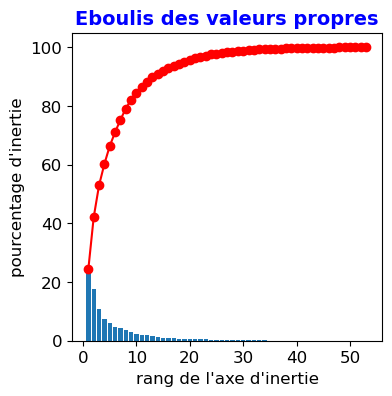

In [21]:
n_comp = X_transform.shape[1]-1
features = X_transform.columns

pipe_pca = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=n_comp))])
X_projeted = pipe_pca.fit_transform(X)
display(pipe_pca.named_steps['pca'].explained_variance_ratio_.cumsum())
X_projeted  = pd.DataFrame(X_projeted[:,0:10])
display_scree_plot(pipe_pca.named_steps['pca'])

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Nous observons que 10 variables issues de l'ACP permet de décrire 84% des données. 

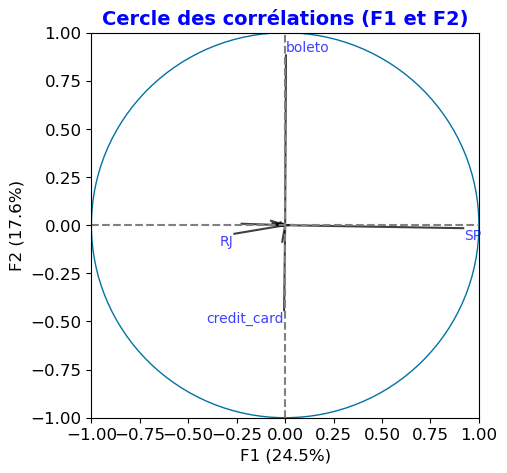

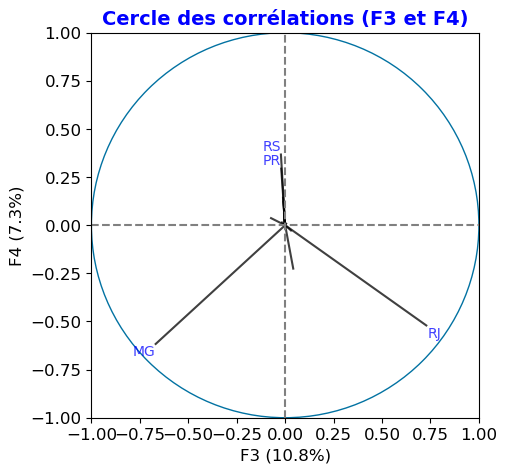

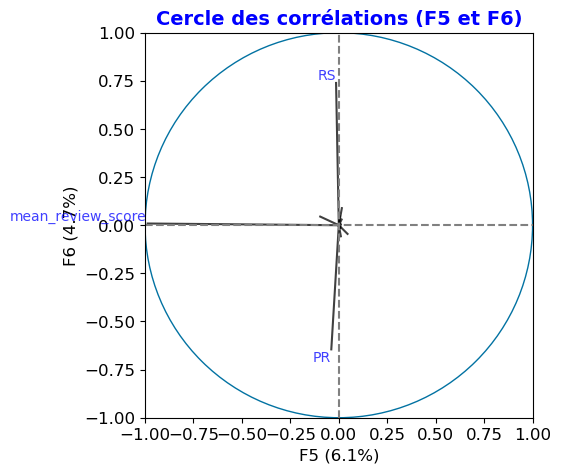

In [24]:
# Cercle des corrélations
pcs = pipe_pca.named_steps['pca'].components_
display_circles(pcs, n_comp, pipe_pca.named_steps['pca'], [(0,1),(2,3),(4,5)],labels = np.array(features))

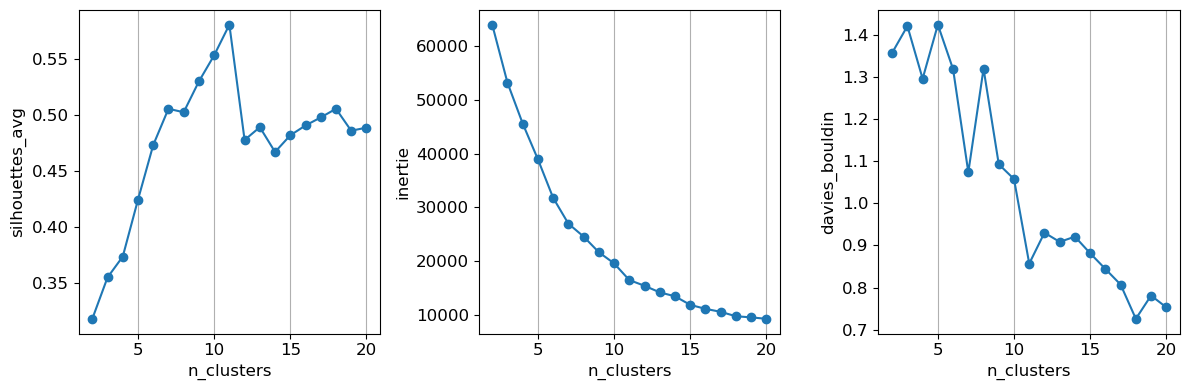

22.57375454902649


In [25]:
t0 = time()
list_clusters = list(range(2,21))
KMeans_parallel(X_projeted,list_clusters,silhouette_analyse=False,score=True)
print(time() - t0)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Le balayage du nombre de cluster avec l'algorithme  du K-means montre qu'un nombre de 11 clusters offre les meilleurs scores 

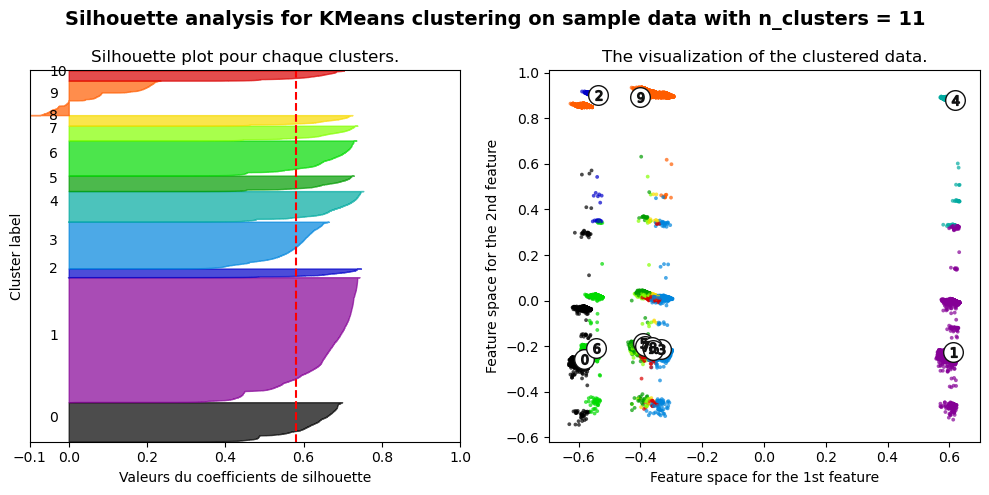

139.90763759613037


In [26]:
t0 = time()
KMeans_parallel(X_projeted,[11],silhouette_analyse=True,score=False)
print(time() - t0)

In [22]:
num_clusters = 11
data_projeted = data_clusters(X_projeted,num_clusters)
group_clients_pca = data_clusters(X_projeted , num_clusters).groupby('kmeans_label').mean().reset_index()
t0 = time()

Y_labels = data_clusters(X_projeted,num_clusters)['kmeans_label']
display(score_stabilité(X_projeted , num_clusters, Y_labels))
display(score_stabilité(X_projeted, num_clusters, Y_labels).describe().iloc[[1,2,3,7]])
print(time() - t0)

inertia  silhouettes_avg  homogeneity       ARI       AMI
0  16908.037400         0.566808     0.951180  0.961726  0.951047
1  18599.671914         0.504586     0.925411  0.805284  0.915158
2  19590.446696         0.478003     0.884820  0.783200  0.873268
3  17033.461373         0.503236     0.924980  0.818164  0.897287
4  21384.285001         0.500249     0.887962  0.903408  0.898779
5  16463.499690         0.578858     0.984924  0.988233  0.983037
6  16900.919882         0.510133     0.970146  0.850836  0.946095
7  16482.676159         0.574862     0.941531  0.961994  0.937632
8  19666.742339         0.410913     0.864642  0.674865  0.829176
9  17832.978191         0.550097     0.965257  0.967909  0.965303

inertia  silhouettes_avg  homogeneity       ARI       AMI
mean  18086.271865         0.517775     0.930085  0.871562  0.919678
std    1669.053997         0.051845     0.040248  0.102409  0.046432
min   16463.499690         0.410913     0.864642  0.674865  0.829176
max   21384.285001         0.578858     0.984924  0.988233  0.983037

14.153851747512817


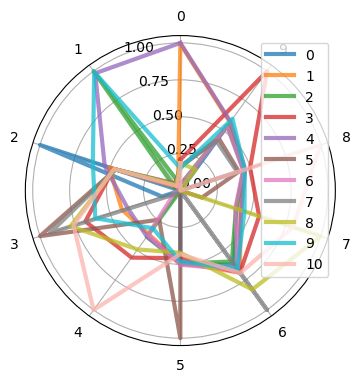

0         1         2         3         4         5         6  \
0   0.000000  0.000000  1.000000  0.131241  0.000000  0.500019  0.619832   
1   0.993805  0.026834  0.506858  0.416256  0.365275  0.489250  0.687817   
2   0.039319  1.000000  0.031839  0.000000  0.386695  0.495726  0.593438   
3   0.208776  0.036507  0.476213  0.676510  0.561608  0.458200  0.687416   
4   1.000000  0.981870  0.538620  0.377028  0.385452  0.482673  0.664278   
5   0.158972  0.058986  0.461471  1.000000  0.243841  1.000000  0.000000   
6   0.032734  0.042747  0.000000  0.039555  0.371403  0.502732  0.663098   
7   0.166094  0.048798  0.461905  0.929097  0.022279  0.000000  1.000000   
8   0.183660  0.046488  0.469792  0.782026  0.493049  0.421012  0.828789   
9   0.151310  0.993200  0.623117  0.605528  0.315723  0.481240  0.656527   
10  0.185484  0.035339  0.473343  0.760691  1.000000  0.430792  0.691145   

           7         8         9  
0   0.398480  0.449248  0.542813  
1   0.428513  0.454856  0.572348  
2   0.396169  0.454753  0.543228  
3   0.561420  0.496586  1.000000  
4   0.433405  0.462368  0.577511  
5   0.154083  0.416611  0.440257  
6   0.391252  0.447400  0.538259  
7   0.000000  0.406229  0.415531  
8   1.000000  0.000000  0.178030  
9   0.456833  0.458161  0.601153  
10  0.801227  1.000000  0.000000

In [28]:
radar_plot(data_projeted)

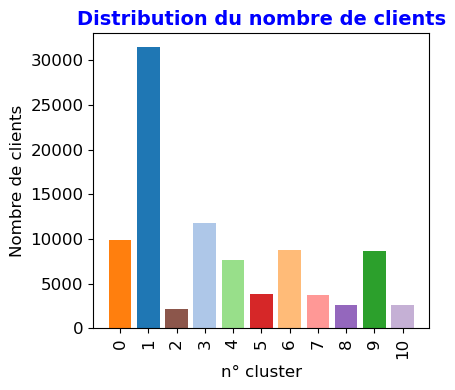

In [29]:
plot_bar(data_projeted,'kmeans_label',Nb_cols=2,title='Distribution du nombre de clients',
         x_name='n° cluster',y_name='Nombre de clients')

619.0863909721375 sec


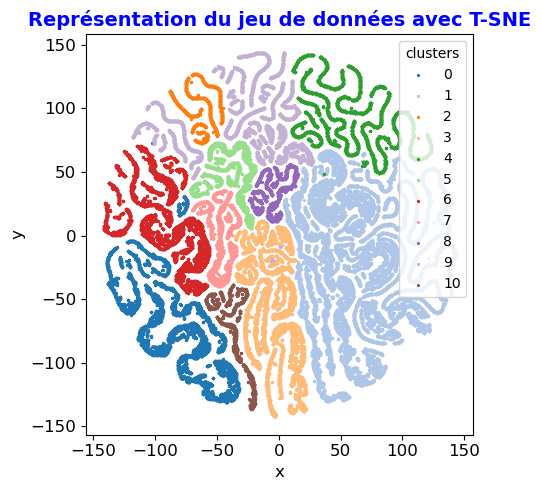

In [23]:
TSNE_X_projeted = TSNE_transform(X_projeted , init = 'pca')
plot_TSNE(TSNE_X_projeted, data_projeted['kmeans_label'],legend='clusters')

## <a STYLE="color:black" id="3.3">3.3 Clustering des clients sans les catégories de produit  </a>
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Nous avons vu dans le paragraphe précédent que la catégorie de produits achetés n'avait pas d'impact sur la segmentation des clients. Dans cette section, nous allons à nouveau utliser l'algorithme du K-means pour segmenter les clients sans les catégories de produits.</b></p>  

## <a STYLE="padding-left:1em;color:black" id="3.3.1">3.3.1 K-means </a>

In [31]:
cols_var_less_cat_product = list(Data.select_dtypes(include=['int64', 'float64']).columns.drop(cols_cat_product))
preprocessor_less_cat_product = ColumnTransformer([('minmax',scaler ,cols_var_less_cat_product),('OHE',scaler_enc, cols_cat)])
X_transform_less_cat_product = preprocessor_less_cat_product.fit_transform(X)
X_transform_less_cat_product = pd.DataFrame(X_transform_less_cat_product, columns =preprocessor_less_cat_product.get_feature_names_out()).rename(label, axis = 1)

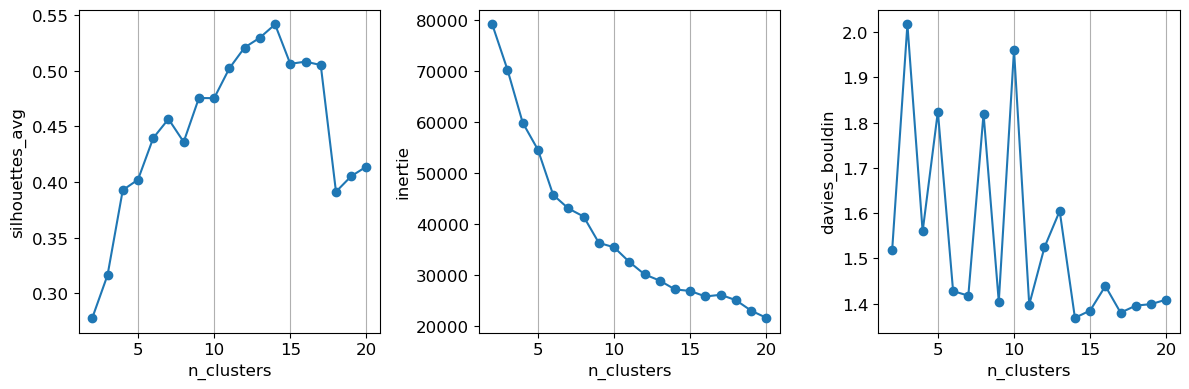

24.22386622428894


In [32]:
t0 = time()
list_clusters = list(range(2,21))
KMeans_parallel(X_transform_less_cat_product,list_clusters,silhouette_analyse=False,score=True)
print(time() - t0)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Le balayage du nombre de clusters avec l'algorithme  du K-means montre qu'un nombre de 14 clusters offre les meilleurs scores soit 3 clusters de plus par rapport à l'analyse précédente  

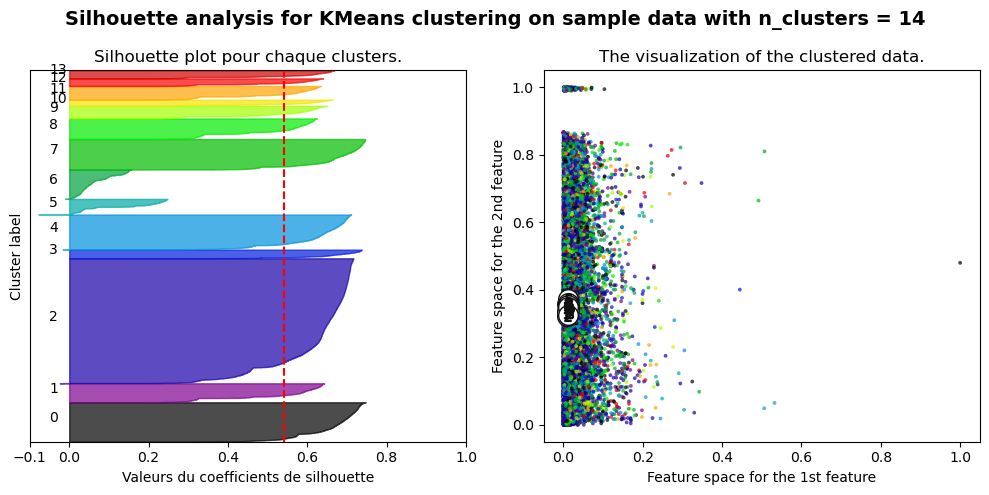

158.92020535469055


In [33]:
t0 = time()
KMeans_parallel(X_transform_less_cat_product,[14],silhouette_analyse=True,score=False)
print(time() - t0)

In [34]:
num_clusters = 14
data_transform_less_cat_product = data_clusters(X_transform_less_cat_product,num_clusters)
group_clients_less_cat_product = clients_clusters(X_transform_less_cat_product , num_clusters,preprocessor_less_cat_product)
group_clients_bis_less_cat_product = data_clusters(X_transform_less_cat_product , num_clusters).groupby('kmeans_label').mean().reset_index()

t0 = time()

Y_labels = data_clusters(X_transform_less_cat_product,num_clusters)['kmeans_label']
display(score_stabilité(X_transform_less_cat_product,num_clusters , Y_labels))
display(score_stabilité(X_transform_less_cat_product , num_clusters, Y_labels).describe().iloc[[1,2,3,7]])
print(time() - t0)

inertia  silhouettes_avg  homogeneity       ARI       AMI
0  26899.372075         0.466692     0.935291  0.820613  0.910669
1  28817.189809         0.464290     0.915129  0.800083  0.900243
2  28286.183481         0.424175     0.924819  0.641674  0.879175
3  30772.543716         0.366662     0.873832  0.663289  0.841776
4  27894.045996         0.476114     0.917746  0.866045  0.903734
5  28812.688095         0.452599     0.901614  0.788092  0.888766
6  30180.152603         0.400009     0.877642  0.768715  0.864737
7  30067.542458         0.387033     0.884125  0.684401  0.863231
8  27987.797026         0.464845     0.909648  0.801006  0.890090
9  28717.495705         0.520193     0.889018  0.933173  0.894355

inertia  silhouettes_avg  homogeneity       ARI       AMI
mean  28843.501096         0.442261     0.902886  0.776709  0.883678
std    1190.124832         0.046900     0.021015  0.091493  0.021445
min   26899.372075         0.366662     0.873832  0.641674  0.841776
max   30772.543716         0.520193     0.935291  0.933173  0.910669

15.636736869812012


<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons un score ARI plus faible par rapport à l'analyse précédente nous indiquant une stabilité des segments plus faible.

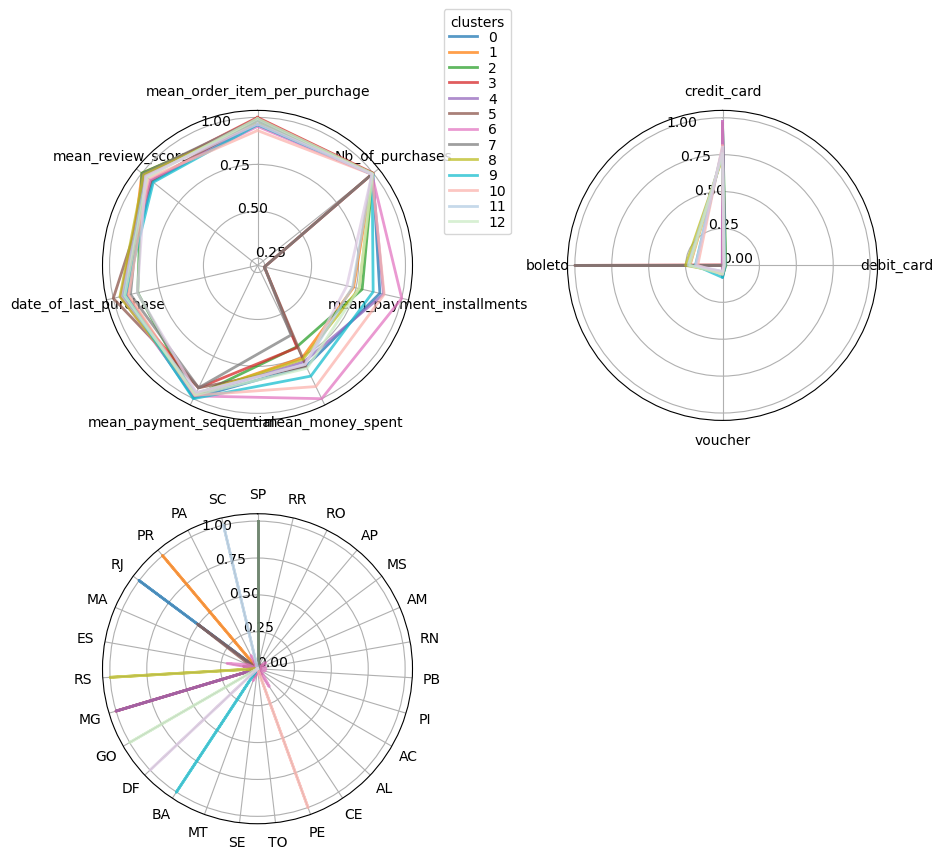

mean_money_spent  date_of_last_purchase  Nb_of_purchases  \
0         169.850127             244.786535         1.036686   
1         159.401833             239.464668         1.033131   
2         145.677583             224.338557         1.036017   
3         146.575996             247.733915         1.038603   
4         164.214071             240.630881         1.031062   
5         169.951191             258.894831         1.030812   
6         209.984854             248.571390         1.029045   
7         130.976532             234.543492         1.028995   
8         161.200182             249.469621         1.034636   
9         181.935403             241.907507         1.031359   
10        194.915247             237.186287         1.028461   
11        167.325410             245.602787         1.028746   
12        172.232058             242.488912         1.034847   
13        167.577832             224.797719         1.030739   

    mean_review_score  mean_payment_sequential  mean_payment_installments  \
0            3.930878                 1.063571                   3.528690   
1            4.221710                 1.042567                   2.952698   
2            4.226517                 1.054344                   3.140739   
3            4.148284                 1.000066                   1.000985   
4            4.170718                 1.049380                   3.608846   
5            3.953569                 1.000085                   1.000149   
6            3.984381                 1.051574                   4.007732   
7            4.201686                 1.000033                   1.000921   
8            4.171988                 1.036813                   3.074900   
9            3.897096                 1.068947                   3.381681   
10           4.043984                 1.047542                   3.623113   
11           4.102618                 1.031238                   2.931523   
12           4.076162                 1.045407                   3.073698   
13           4.119650                 1.029747                   2.806478   

    mean_order_item_per_purchage  credit_card    boleto   voucher  debit_card  \
0                       1.136910     0.962902  0.001268  0.081612    0.017789   
1                       1.144545     0.751520  0.220696  0.055567    0.014783   
2                       1.139738     0.959520  0.001108  0.071007    0.022708   
3                       1.172159     0.003107  0.995744  0.000525    0.000689   
4                       1.126288     0.972698  0.000435  0.061567    0.014681   
5                       1.157605     0.000127  0.998854  0.000764    0.000340   
6                       1.116345     0.970186  0.001244  0.063111    0.017033   
7                       1.162116     0.000878  0.998104  0.000466    0.000585   
8                       1.142044     0.728570  0.249742  0.044472    0.014029   
9                       1.127019     0.787868  0.183149  0.081776    0.016155   
10                      1.090587     0.807383  0.168037  0.061125    0.010996   
11                      1.149729     0.745499  0.232578  0.040384    0.012776   
12                      1.165479     0.753520  0.222721  0.057550    0.011616   
13                      1.131383     0.798463  0.181210  0.041646    0.008428   

          AC        AL        AM        AP   BA        CE   DF        ES   GO  \
0   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
1   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
2   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
3   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
4   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
5   0.004074  0.015788  0.005093  0.004584  0.0  0.048638  0.0  0.096766  0.0   
6   0.008143  0.044110  0.016287  0.006515  0.0  0.144680  0.0  0.209962  0.0   
7   0.000000  0.000000 

In [35]:
radar_plot_normalize_cat(group_clients_less_cat_product)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> La projection des moyennes des différentes variables normalisées en fonction des différents clusters montrent les mêmes résultats où nous avons les variables indiquant la dépense moyenne par client, le nombre de versement moyen par achat, les moyens de paiement et la localisation des clients sont utilisés par l'algorithme pour segmenter les clients.

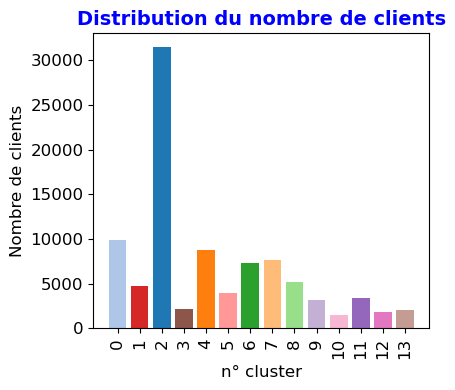

In [36]:
plot_bar( data_transform_less_cat_product,'kmeans_label',Nb_cols=2,title='Distribution du nombre de clients',
         x_name='n° cluster',y_name='Nombre de clients')

982.5597779750824 sec


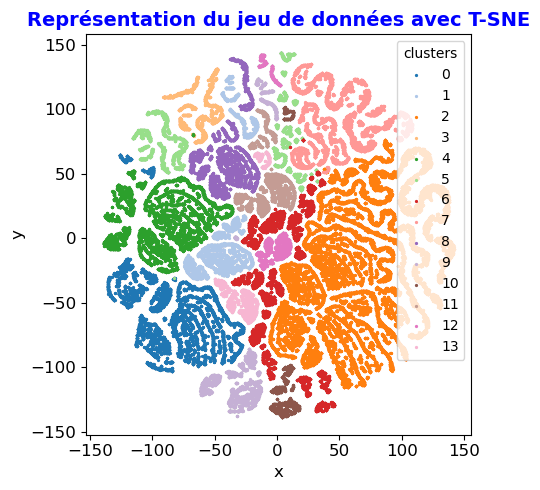

In [37]:
TSNE_X_transform_less_cat_product = TSNE_transform(X_transform_less_cat_product , init = 'pca')
plot_TSNE(TSNE_X_transform_less_cat_product, data_transform_less_cat_product['kmeans_label'],legend='clusters')

## <a STYLE="padding-left:1em;color:black" id="3.3.2">3.3.2 K-means après réduction dimensionnelle - PCA </a>

array([0.24788157, 0.42569455, 0.53527621, 0.6089077 , 0.67042756,
       0.7179539 , 0.76084626, 0.79920935, 0.83055965, 0.85454143,
       0.87344895, 0.8916757 , 0.90721715, 0.91993261, 0.92969723,
       0.93870974, 0.94713279, 0.95431442, 0.96129175, 0.96786047,
       0.97304811, 0.9776806 , 0.98211056, 0.98591817, 0.98914709,
       0.99178196, 0.99403685, 0.99545508, 0.99683965, 0.99759775,
       0.99824596, 0.99885862, 0.99925301, 0.99960827, 0.99980969,
       1.        , 1.        ])

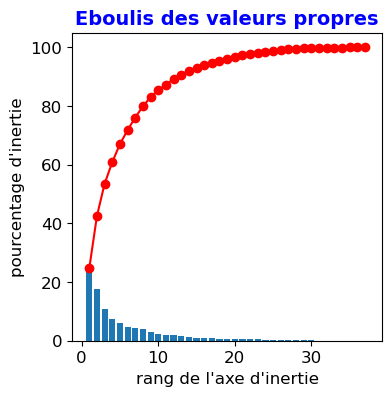

In [38]:
n_comp_less_cat_product = X_transform_less_cat_product.shape[1]-1
features_less_cat_product = X_transform_less_cat_product.columns

pipe_pca_less_cat_product = Pipeline([('preprocessor_less_cat_product', preprocessor_less_cat_product), ('pca_less_cat_product', PCA(n_components=n_comp_less_cat_product))])
X_projeted_less_cat_product = pipe_pca_less_cat_product.fit_transform(X)
display(pipe_pca_less_cat_product.named_steps['pca_less_cat_product'].explained_variance_ratio_.cumsum())
X_projeted_less_cat_product = pd.DataFrame(X_projeted_less_cat_product[:,0:10])
display_scree_plot(pipe_pca_less_cat_product.named_steps['pca_less_cat_product'])

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Nous observons que 10 variables issues de l'ACP permet de décrire 85% des données. 

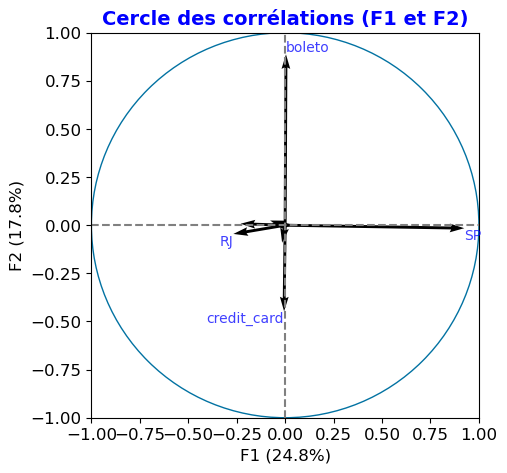

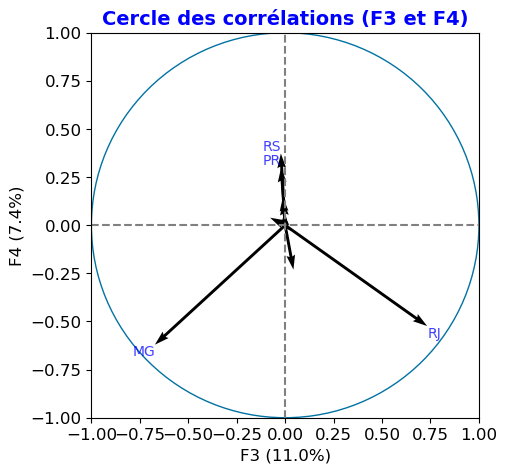

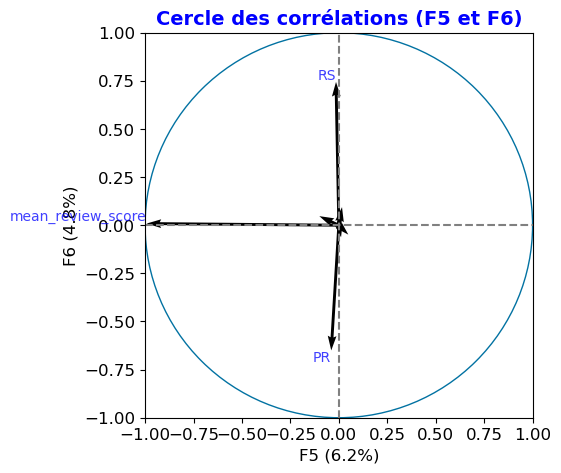

In [39]:
# Cercle des corrélations
pcs_less_cat_product = pipe_pca_less_cat_product.named_steps['pca_less_cat_product'].components_
display_circles(pcs_less_cat_product, n_comp_less_cat_product, pipe_pca_less_cat_product.named_steps['pca_less_cat_product'],[(0,1),(2,3),(4,5)], 
                labels = np.array(features_less_cat_product))

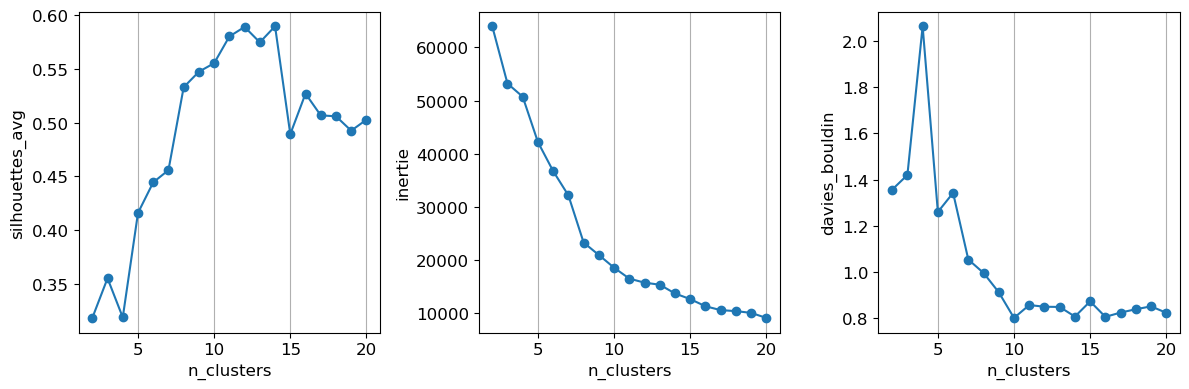

22.547327280044556


In [40]:
t0 = time()
list_clusters = list(range(2,21))
KMeans_parallel(X_projeted_less_cat_product,list_clusters,silhouette_analyse=False,score=True)
print(time() - t0)

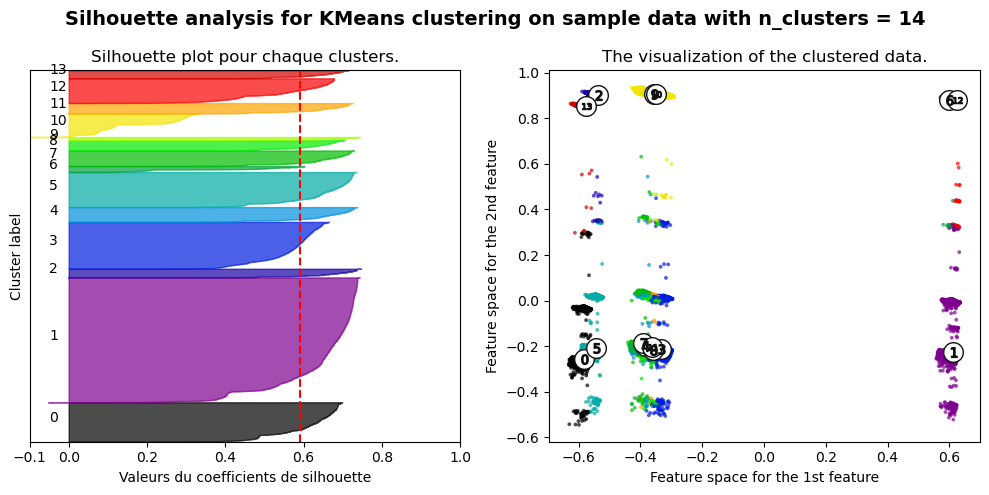

138.65289998054504


In [42]:
t0 = time()
KMeans_parallel(X_projeted_less_cat_product,[14],silhouette_analyse=True,score=False)
print(time() - t0)

In [43]:
num_clusters = 14
group_clients_pca_less_cat_product = data_clusters(X_projeted_less_cat_product , num_clusters).groupby('kmeans_label').mean().reset_index()

t0 = time()
Y_labels = data_clusters(X_projeted_less_cat_product,num_clusters)['kmeans_label']
display(score_stabilité(X_projeted_less_cat_product ,num_clusters, Y_labels))
display(score_stabilité( X_projeted_less_cat_product, num_clusters, Y_labels).describe().iloc[[1,2,3,7]])
print(time() - t0)

inertia  silhouettes_avg  homogeneity       ARI       AMI
0  12316.177412         0.557304     0.967691  0.844681  0.940355
1  13987.468267         0.463149     0.945144  0.722762  0.901799
2  13601.015306         0.463908     0.938183  0.715751  0.892552
3  15214.243810         0.458509     0.892267  0.594446  0.837105
4  14958.215567         0.482118     0.939063  0.795314  0.904280
5  13456.002220         0.492600     0.942394  0.638518  0.883070
6  13175.919133         0.504070     0.949311  0.745663  0.911918
7  13667.142624         0.525283     0.934665  0.652669  0.887025
8  13334.827320         0.560665     0.967562  0.948551  0.953358
9  14143.485292         0.498256     0.918483  0.781265  0.886219

inertia  silhouettes_avg  homogeneity       ARI       AMI
mean  13785.449695         0.500586     0.939476  0.743962  0.899768
std     848.248570         0.037082     0.022153  0.104926  0.032136
min   12316.177412         0.458509     0.892267  0.594446  0.837105
max   15214.243810         0.560665     0.967691  0.948551  0.953358

14.07226014137268


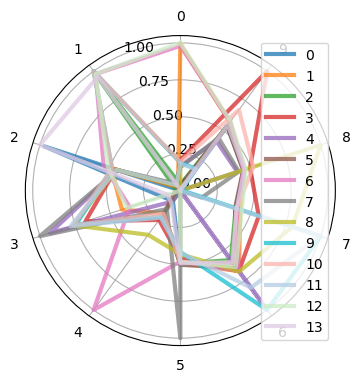

0         1         2         3         4         5         6  \
0   0.000000  0.000000  0.968771  0.131219  0.085935  0.500077  0.607480   
1   0.990010  0.026768  0.491034  0.416241  0.190001  0.489319  0.675783   
2   0.039179  0.995749  0.030840  0.000000  0.196034  0.495783  0.581992   
3   0.207996  0.036796  0.461366  0.676450  0.245905  0.458287  0.674710   
4   0.165468  0.049077  0.447500  0.929048  0.091901  0.000000  0.978041   
5   0.032615  0.043062  0.000000  0.039552  0.191668  0.502787  0.650234   
6   0.980571  0.975717  0.546020  0.360074  1.000000  0.480648  0.673045   
7   0.158369  0.059219  0.447068  1.000000  0.154629  1.000000  0.000000   
8   0.184791  0.035677  0.458585  0.760645  0.370782  0.430902  0.678854   
9   0.189013  1.000000  0.485732  0.743120  0.218340  0.416143  1.000000   
10  0.194363  0.998871  0.485907  0.760265  0.194222  0.485990  0.610993   
11  0.182957  0.045980  0.455116  0.782014  0.226327  0.421092  0.813431   
12  1.000000  0.975872  0.515848  0.381199  0.000000  0.483205  0.639787   
13  0.006100  0.952460  1.000000  0.091541  0.103155  0.493529  0.599233   

           7         8         9  
0   0.396456  0.449141  0.542725  
1   0.426338  0.454751  0.572276  
2   0.394162  0.454654  0.543150  
3   0.558565  0.496460  1.000000  
4   0.000000  0.406116  0.415410  
5   0.389267  0.447297  0.538174  
6   0.404985  0.449766  0.575261  
7   0.153237  0.416487  0.440121  
8   0.797204  1.000000  0.000000  
9   1.000000  0.007764  0.183176  
10  0.398847  0.519599  0.675775  
11  0.995227  0.000000  0.177855  
12  0.437596  0.465285  0.577954  
13  0.400828  0.456358  0.547780

In [44]:
data_projeted_less_cat_product = data_clusters(X_projeted_less_cat_product,num_clusters)
radar_plot(data_projeted_less_cat_product)

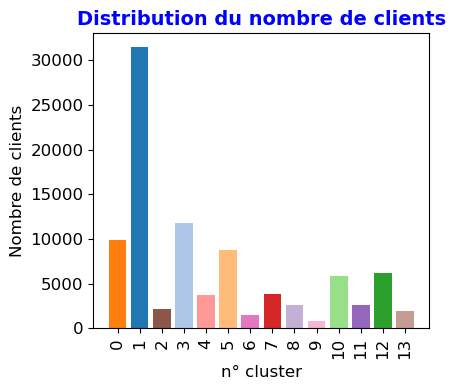

In [45]:
plot_bar( data_projeted_less_cat_product,'kmeans_label',Nb_cols=2,title='Distribution du nombre de clients',
         x_name='n° cluster',y_name='Nombre de clients')

608.7997000217438 sec


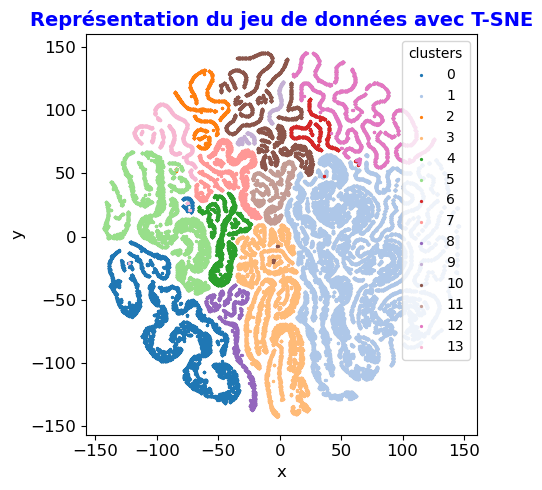

In [46]:
TSNE_X_projeted_less_cat_product = TSNE_transform(X_projeted_less_cat_product , init = 'pca')
plot_TSNE(TSNE_X_projeted_less_cat_product, data_projeted_less_cat_product['kmeans_label'],legend='clusters')

# <a STYLE="color:black" id="4">Etape 4 : Segmentation des clients avec d'autres algorithmes de clustering 
## <a STYLE="color:black" id="4.1">4.1 Algorithme du DBSCAN</a> 

In [26]:
def plot_DBSCAN(DF,db) : 
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Nombre de clusters estimés: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    if n_clusters_>1:
        print("Silhouette Coefficient: %0.3f" % silhouette_score(DF[0],labels,sample_size=DF[0].sample(frac=0.10).shape[0]))

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    fig = plt.figure(figsize=(8,4)) if len(DF)==2 else plt.figure(figsize=(4,4))
    for i , X in enumerate(DF): 
        axes = fig.add_subplot(1,2,i+1)    
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            size1 = 7 if k==-1 else 14
            size2 = 4 if k==-1 else 6
            class_member_mask = labels == k
            xy = X[class_member_mask & core_samples_mask]
            axes.plot(xy.iloc[:, 0],xy.iloc[:, 1],"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=size1)

            xy = X[class_member_mask & ~core_samples_mask]
            axes.plot(xy.iloc[:, 0],xy.iloc[:, 1],"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=size2,)
            axes.set_title("Nombre de clusters estimés: %d" % n_clusters_)
    plt.show()

In [28]:
list_eps = [0.5,1,1.5] 
list_min_samples = [5 , 10 , 15]
def dbscan(DF, TSNE , list_eps , list_min_samples ) : 
    list_db = [] 
    for i in list_eps :
        for j in list_min_samples :
            db = DBSCAN(eps=i, min_samples=j, n_jobs = -1).fit(DF)
            list_db.append(db)
            print(f'eps={i} ; min_samples={j}')
            plot_DBSCAN([DF,TSNE],db)
    return list_db     

eps=0.5 ; min_samples=5
Nombre de clusters estimés: 73
Estimated number of noise points: 215
Silhouette Coefficient: 0.481


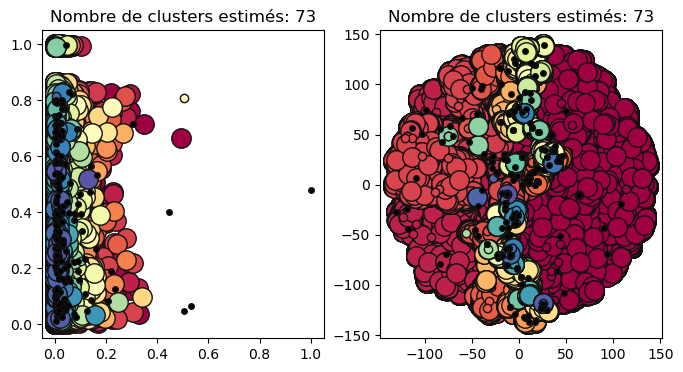

eps=0.5 ; min_samples=10
Nombre de clusters estimés: 63
Estimated number of noise points: 326
Silhouette Coefficient: 0.513


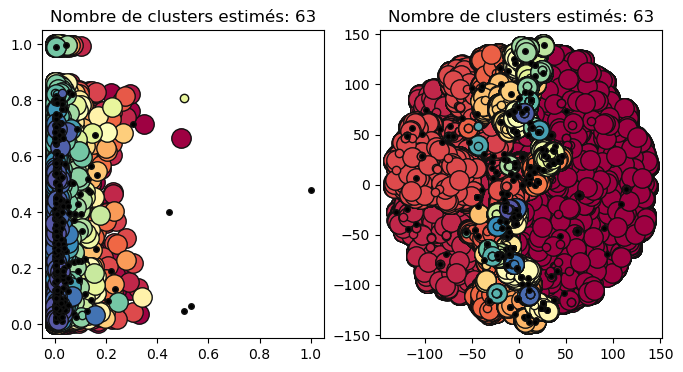

eps=0.5 ; min_samples=15
Nombre de clusters estimés: 59
Estimated number of noise points: 402
Silhouette Coefficient: 0.514


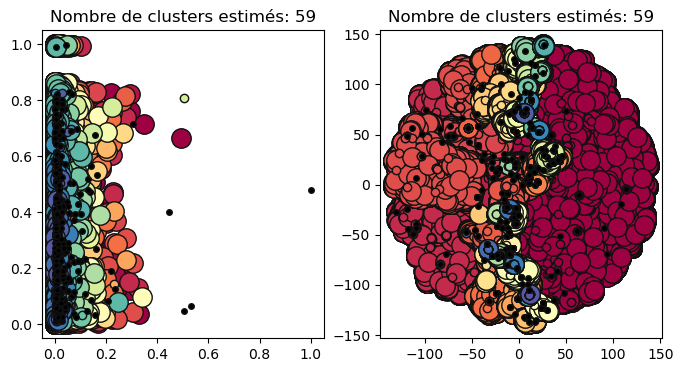

eps=1 ; min_samples=5
Nombre de clusters estimés: 33
Estimated number of noise points: 5
Silhouette Coefficient: 0.509


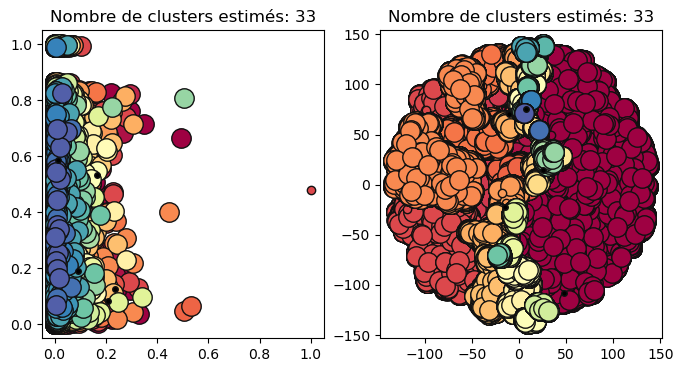

eps=1 ; min_samples=10
Nombre de clusters estimés: 33
Estimated number of noise points: 5
Silhouette Coefficient: 0.513


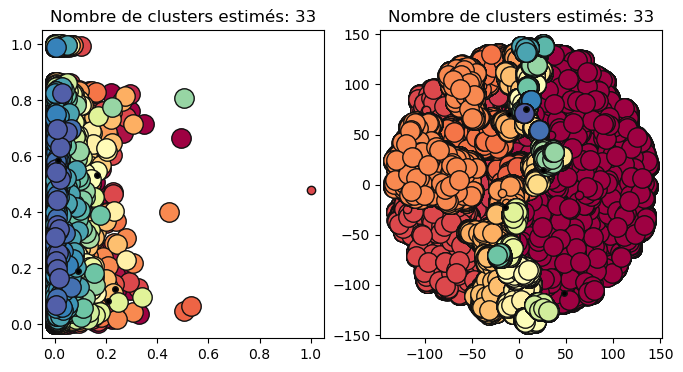

eps=1 ; min_samples=15
Nombre de clusters estimés: 32
Estimated number of noise points: 16
Silhouette Coefficient: 0.511


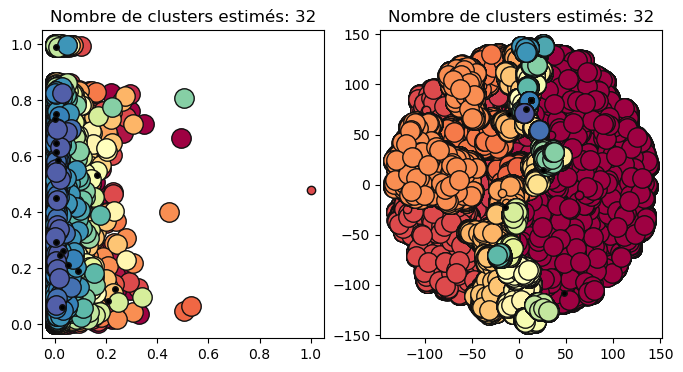

eps=1.5 ; min_samples=5
Nombre de clusters estimés: 1
Estimated number of noise points: 0


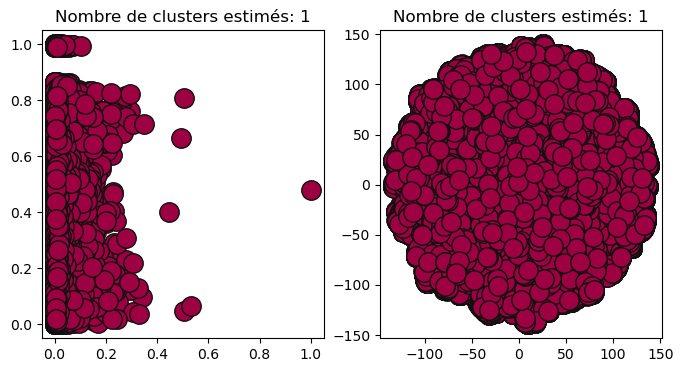

eps=1.5 ; min_samples=10
Nombre de clusters estimés: 1
Estimated number of noise points: 0


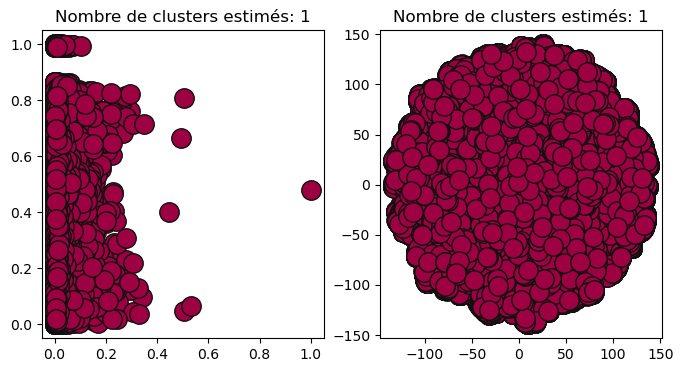

eps=1.5 ; min_samples=15
Nombre de clusters estimés: 1
Estimated number of noise points: 0


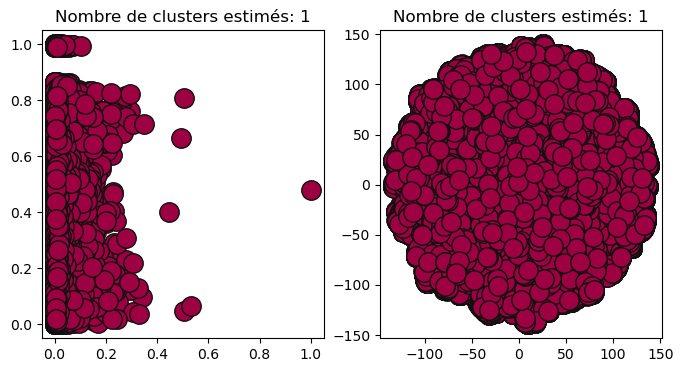

[DBSCAN(n_jobs=-1),
 DBSCAN(min_samples=10, n_jobs=-1),
 DBSCAN(min_samples=15, n_jobs=-1),
 DBSCAN(eps=1, n_jobs=-1),
 DBSCAN(eps=1, min_samples=10, n_jobs=-1),
 DBSCAN(eps=1, min_samples=15, n_jobs=-1),
 DBSCAN(eps=1.5, n_jobs=-1),
 DBSCAN(eps=1.5, min_samples=10, n_jobs=-1),
 DBSCAN(eps=1.5, min_samples=15, n_jobs=-1)]

In [52]:
dbscan(X_transform,TSNE_X_transform, list_eps , list_min_samples)

eps=0.5 ; min_samples=5
Nombre de clusters estimés: 9
Estimated number of noise points: 0
Silhouette Coefficient: 0.478


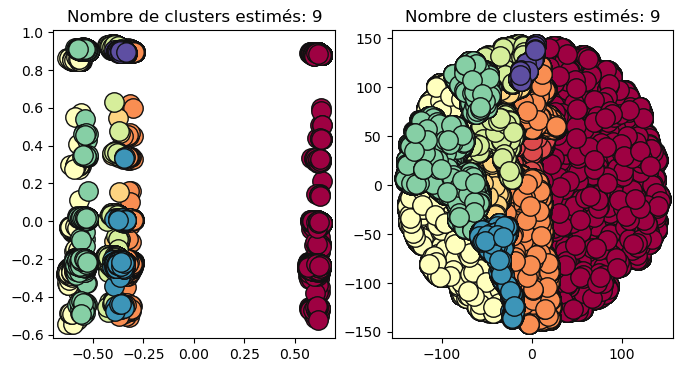

eps=0.5 ; min_samples=10
Nombre de clusters estimés: 9
Estimated number of noise points: 0
Silhouette Coefficient: 0.475


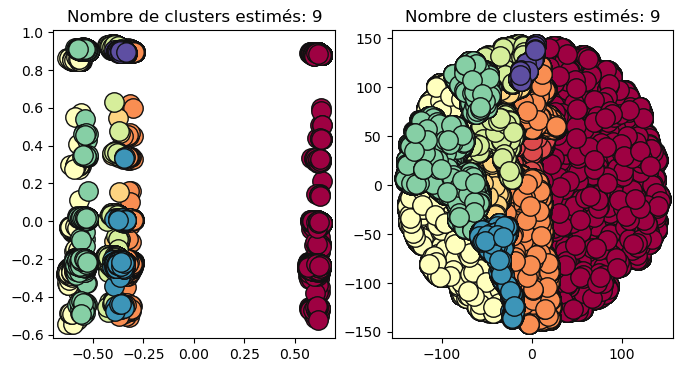

eps=0.5 ; min_samples=15
Nombre de clusters estimés: 9
Estimated number of noise points: 0
Silhouette Coefficient: 0.474


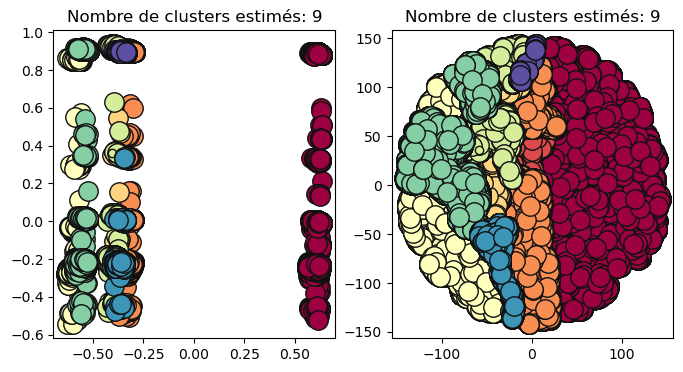

eps=1 ; min_samples=5
Nombre de clusters estimés: 1
Estimated number of noise points: 0


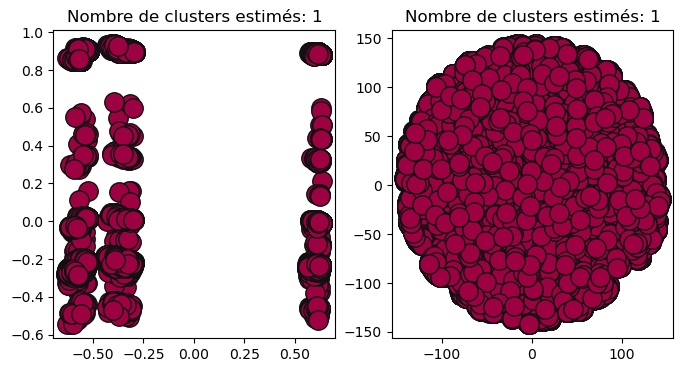

eps=1 ; min_samples=10
Nombre de clusters estimés: 1
Estimated number of noise points: 0


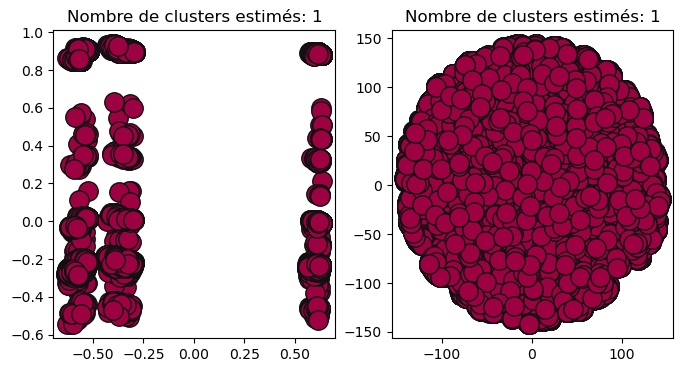

eps=1 ; min_samples=15
Nombre de clusters estimés: 1
Estimated number of noise points: 0


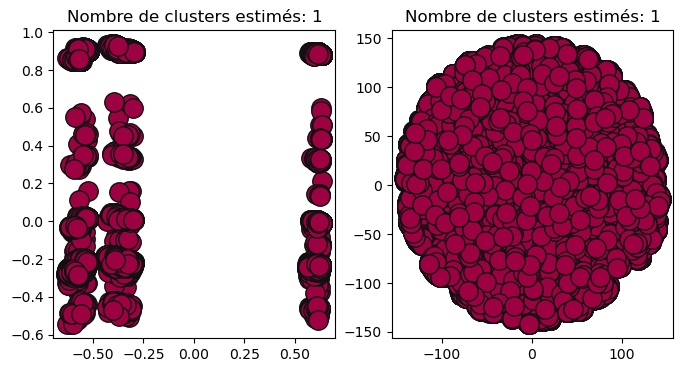

[DBSCAN(n_jobs=-1),
 DBSCAN(min_samples=10, n_jobs=-1),
 DBSCAN(min_samples=15, n_jobs=-1),
 DBSCAN(eps=1, n_jobs=-1),
 DBSCAN(eps=1, min_samples=10, n_jobs=-1),
 DBSCAN(eps=1, min_samples=15, n_jobs=-1)]

In [29]:
list_eps = [0.5,1] 
list_min_samples = [5 , 10 , 15]
dbscan(X_projeted,TSNE_X_projeted, list_eps , list_min_samples)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Nous observons que le nombre de clusters identifié par l'algorithme du DBSCAN est très sensible à ses paramètres et notamment au paramètre <span STYLE="color:gray;" ><i> 'eps' </i></span> qui décrit la distance maximale entre deux échantillons. Ceci nous suggère que cet algorithme n'est pas adapté pour segmenter les clients.

## <a STYLE="color:black" id="4.2">4.2 Algorithme d'agglomerative hierarchical clustering</a>

In [30]:
@mem.cache
def AHC(DF, n_clusters,linkage='ward') : 
    AC = AgglomerativeClustering(n_clusters = n_clusters,linkage=linkage).fit(DF)
    AC_labels = pd.DataFrame(AC.labels_,index =DF.index ,columns = ['kmeans_label'])
    return AC_labels

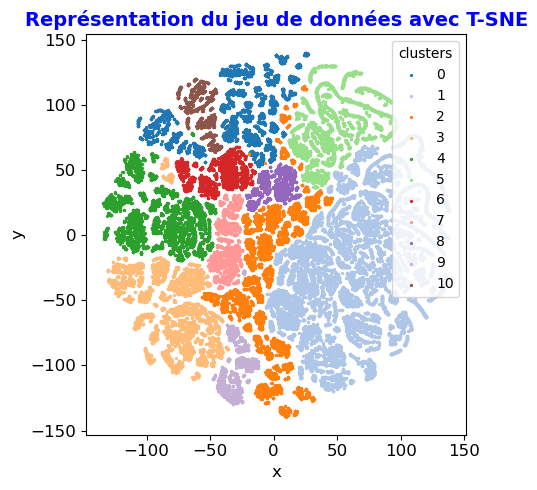

955.1712090969086


In [31]:
t0 = time()
AC_label = AHC(X_transform.sample(frac = 0.7),11,linkage='ward')
plot_TSNE(TSNE_X_transform.loc[AC_label.index],AC_label,legend='clusters')
print(time() - t0)

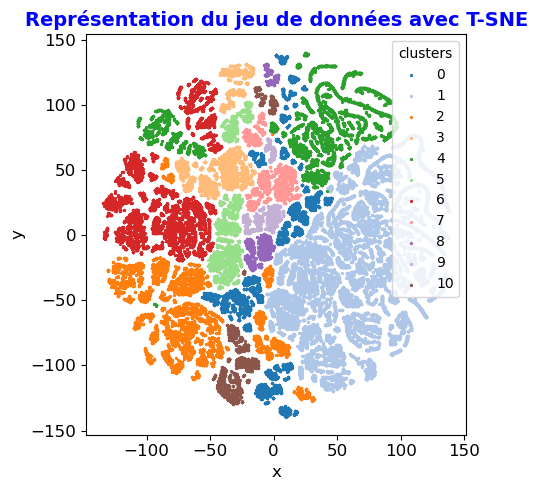

1054.9002332687378


In [32]:
t0 = time()
AC_label_02 = AHC(X_transform.sample(frac = 0.7),11,linkage='complete')
plot_TSNE(TSNE_X_transform.loc[AC_label_02.index],AC_label_02,legend='clusters' )
print(time() - t0)

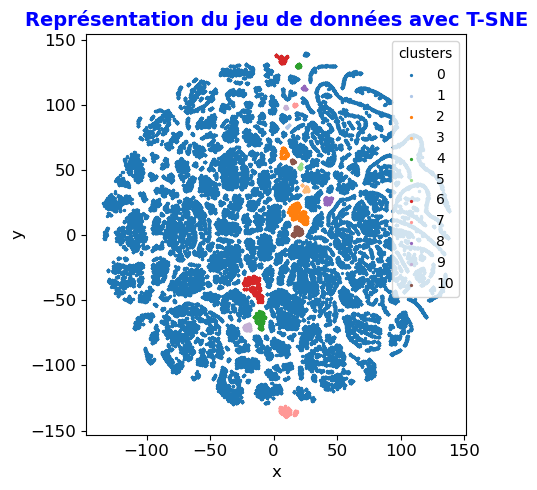

333.0435485839844


In [33]:
t0 = time()
AC_label_01 = AHC(X_transform,11,linkage='single')
plot_TSNE(TSNE_X_transform.loc[AC_label_01.index],AC_label_01,legend='clusters' )
print(time() - t0)

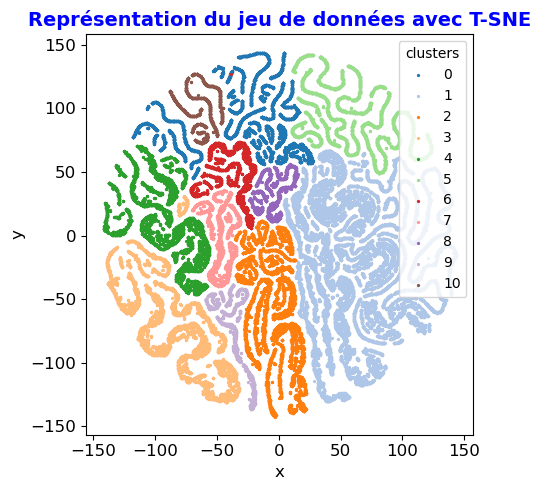

702.2204766273499


In [34]:
t0 = time()
AC_pca_label = AHC(X_projeted.sample(frac = 0.7),11,linkage='ward')
plot_TSNE(TSNE_X_projeted.loc[AC_pca_label.index], AC_pca_label,legend='clusters')
print(time() - t0)

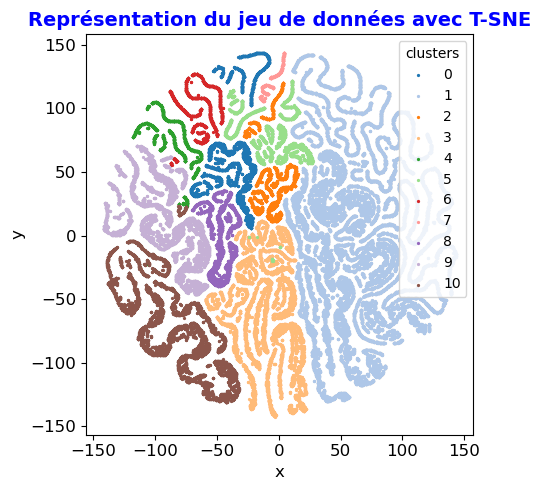

789.8918812274933


In [35]:
t0 = time()
AC_pca_label_02 = AHC(X_projeted.sample(frac = 0.7),11,linkage='complete')
plot_TSNE(TSNE_X_projeted.loc[AC_pca_label_02.index], AC_pca_label_02,legend='clusters')
print(time() - t0)

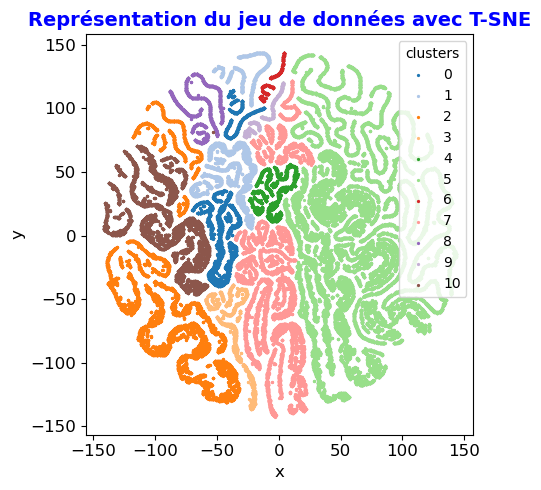

103.42394423484802


In [36]:
t0 = time()
AC_pca_label_01 = AHC(X_projeted,11,linkage='single')
plot_TSNE(TSNE_X_projeted.loc[AC_pca_label_01.index], AC_pca_label_01,legend='clusters')
print(time() - t0)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> L'algorithme agglomerative hierarchical clustering nécessite des ressources de calculs importantes. Une fraction (dans notre cas 70%) du jeu de données ne peut être qu'utilisé pour effectuer la modélisation. Cet algorithme n'est donc pas adapté pour notre étude du fait du temps de calcul important.